In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import scanpy.external as scex
import sklearn.metrics
import seaborn as sns
from matplotlib import pyplot as plt
import scanpyHelpers as scH


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import sklearn.metrics
from matplotlib import pyplot as plt
import seaborn as sns

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-pac

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [4]:
#%matplotlib inline

In [5]:
writeDir = "write/"

fileName = "luadDost"

resultsFileQC = writeDir + fileName + '_QC.h5ad' 


In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [7]:
inDir = 'data/LUAD/GSE149655_RAW'

In [8]:
inputData1 = f'{inDir}/adeno1'
inputData2 = f'{inDir}/adeno2'


In [14]:
adata1 = sc.read_10x_mtx(inputData1, prefix="GSM4506701_Case3_ade1_",cache=True)
adata1

adata2 = sc.read_10x_mtx(inputData2, prefix="GSM4506699_Case2_ade1_",cache=True)
adata2

... reading from cache file cache/data-LUAD-GSE149655_RAW-adeno1-GSM4506701_Case3_ade1_matrix.h5ad
... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 2797 × 33538
    var: 'gene_ids', 'feature_types'

In [41]:
adata = sc.concat((adata1,adata2), label="source")
adata

AnnData object with n_obs × n_vars = 6093 × 33538
    obs: 'source'

In [42]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

In [45]:
adata

AnnData object with n_obs × n_vars = 6093 × 33538
    obs: 'source'

# Start QC
investigate highest expressed genes

normalizing counts per cell
    finished (0:00:00)


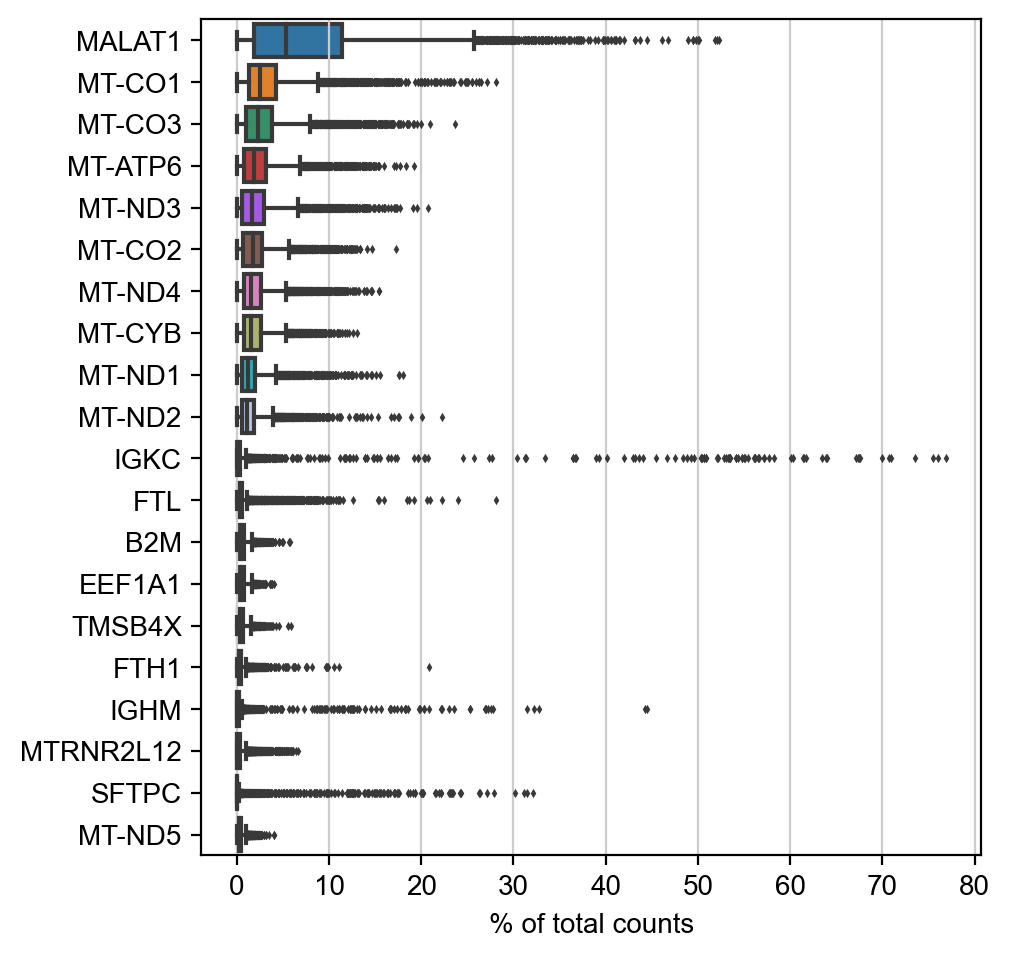

In [46]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_95760/3454098912.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


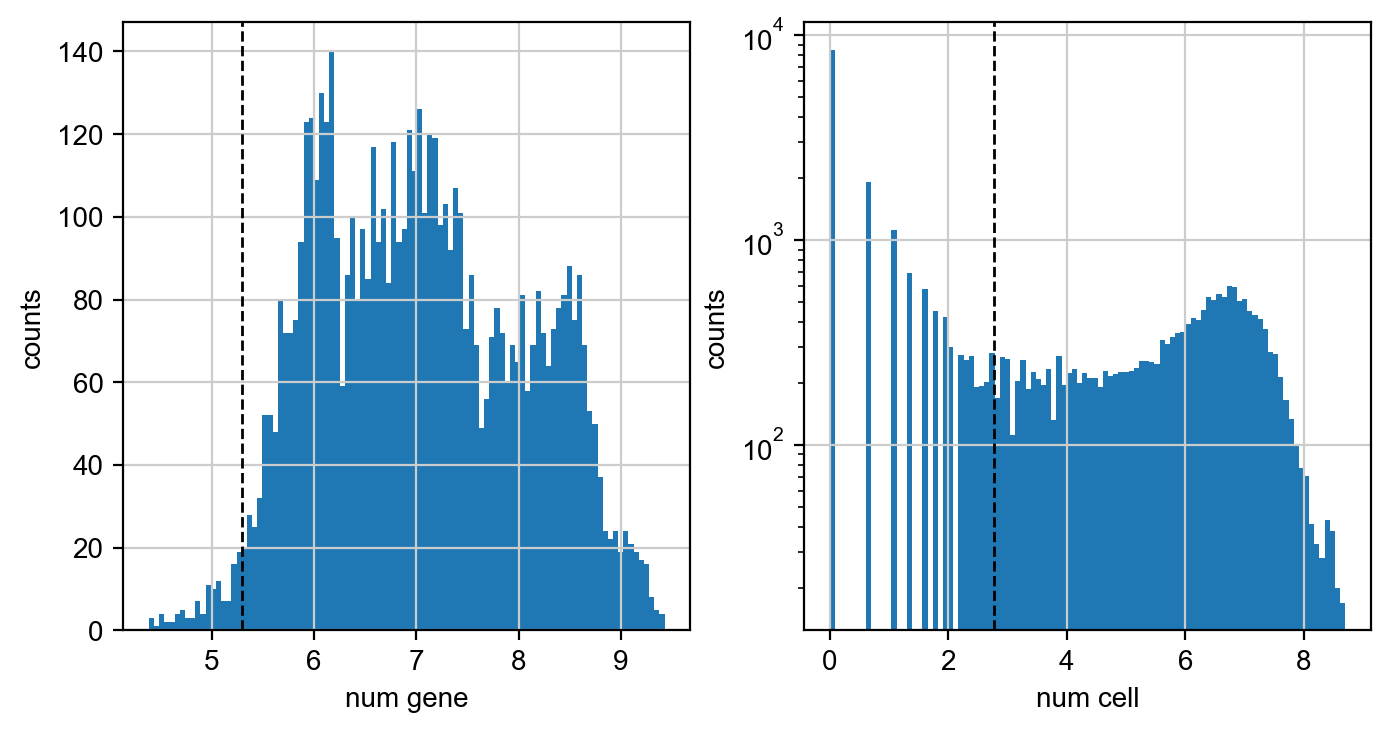

In [47]:
valX = adata.X>0
minGenes=200
minCells=15

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [48]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 120 cells that have less than 200 genes expressed
filtered out 15481 genes that are detected in less than 15 cells


In [49]:
adata = adata[:,np.logical_not(adata.var_names=="MALAT1")]

## Mito QC

In [50]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_95760/2933791377.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')


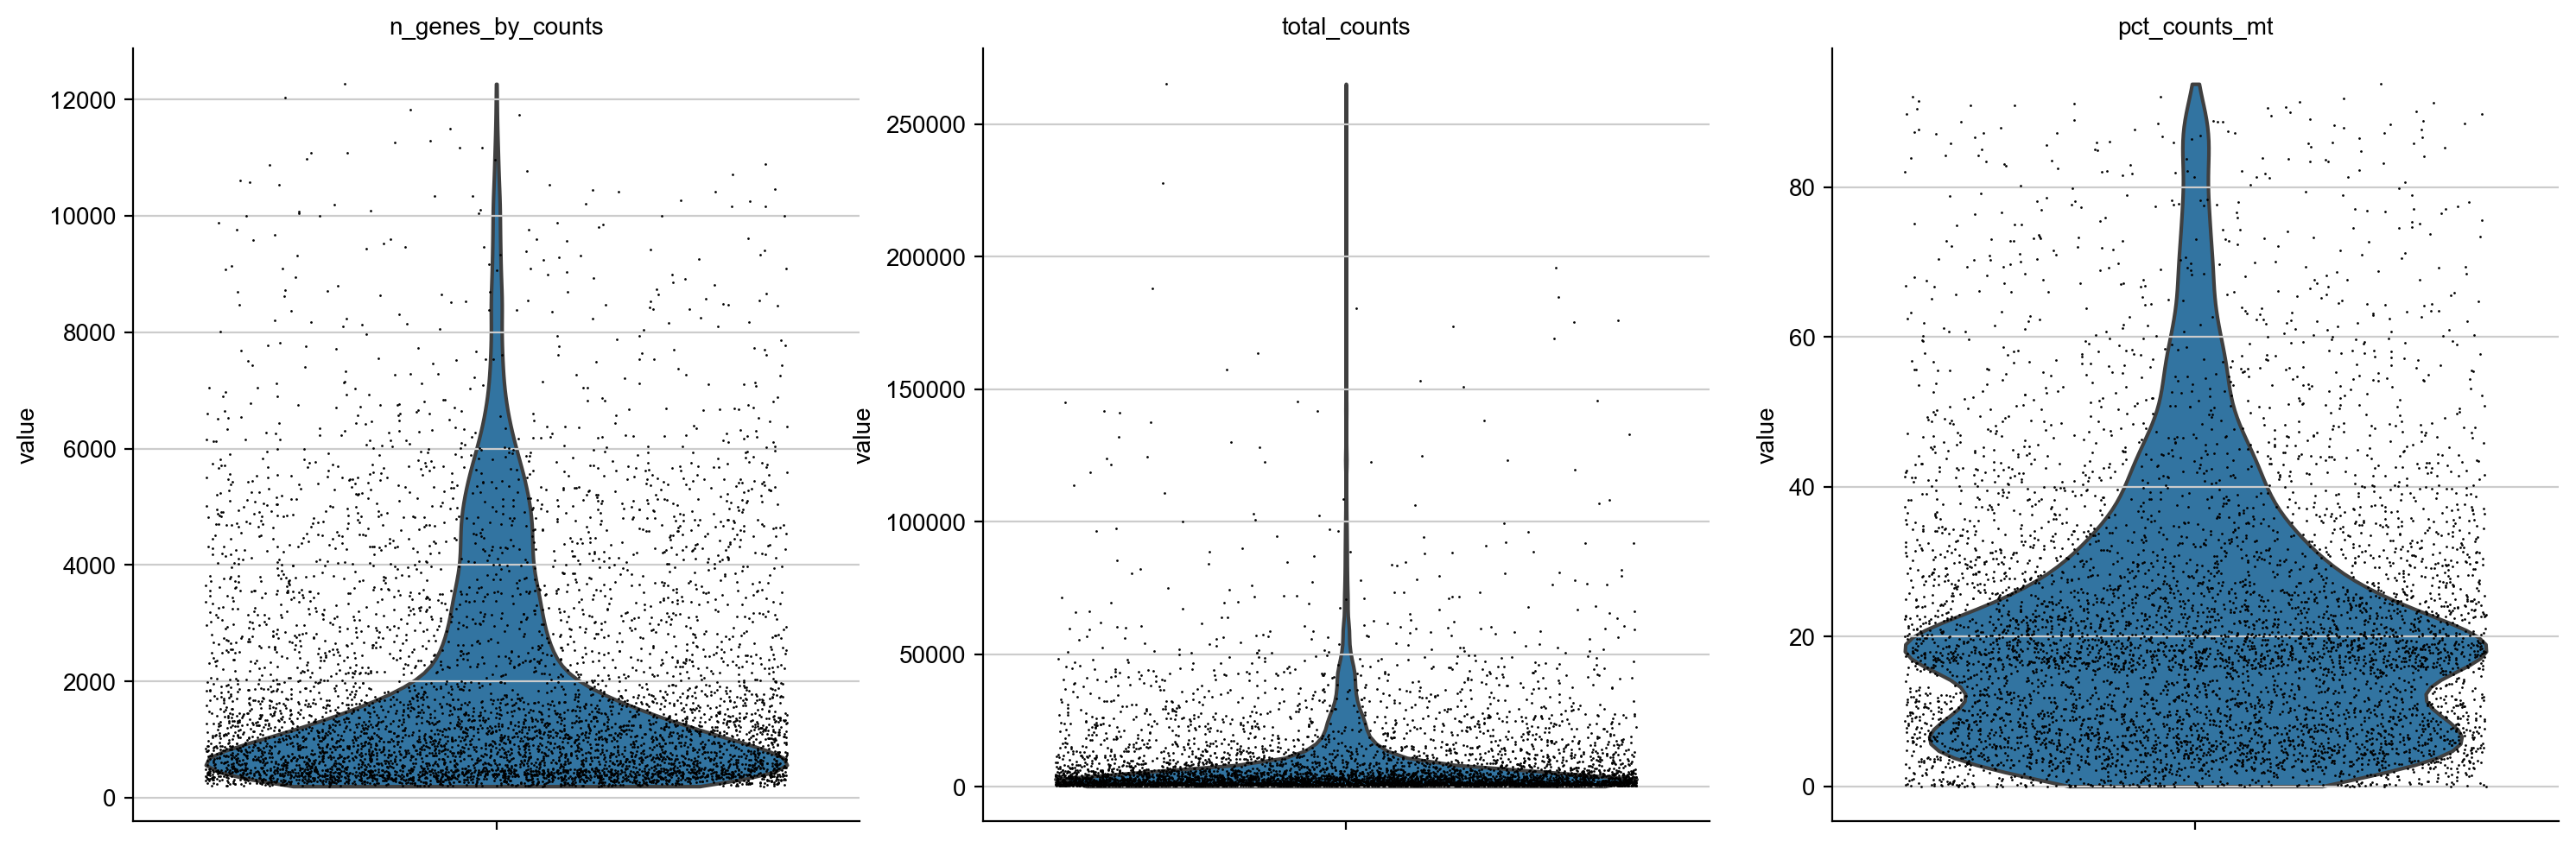

In [51]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

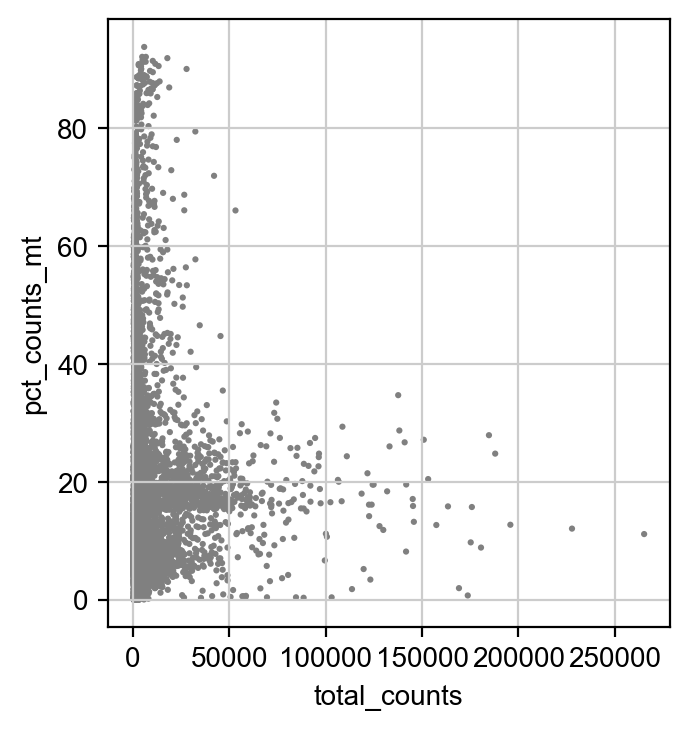

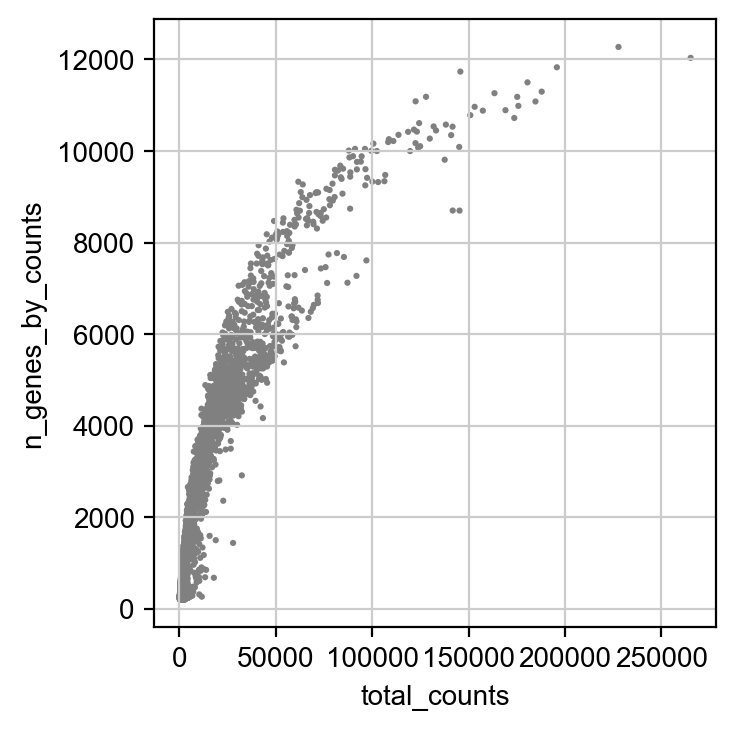

In [52]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

remove cells that have too much mito or could be doublets

In [53]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.total_counts < 20000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]

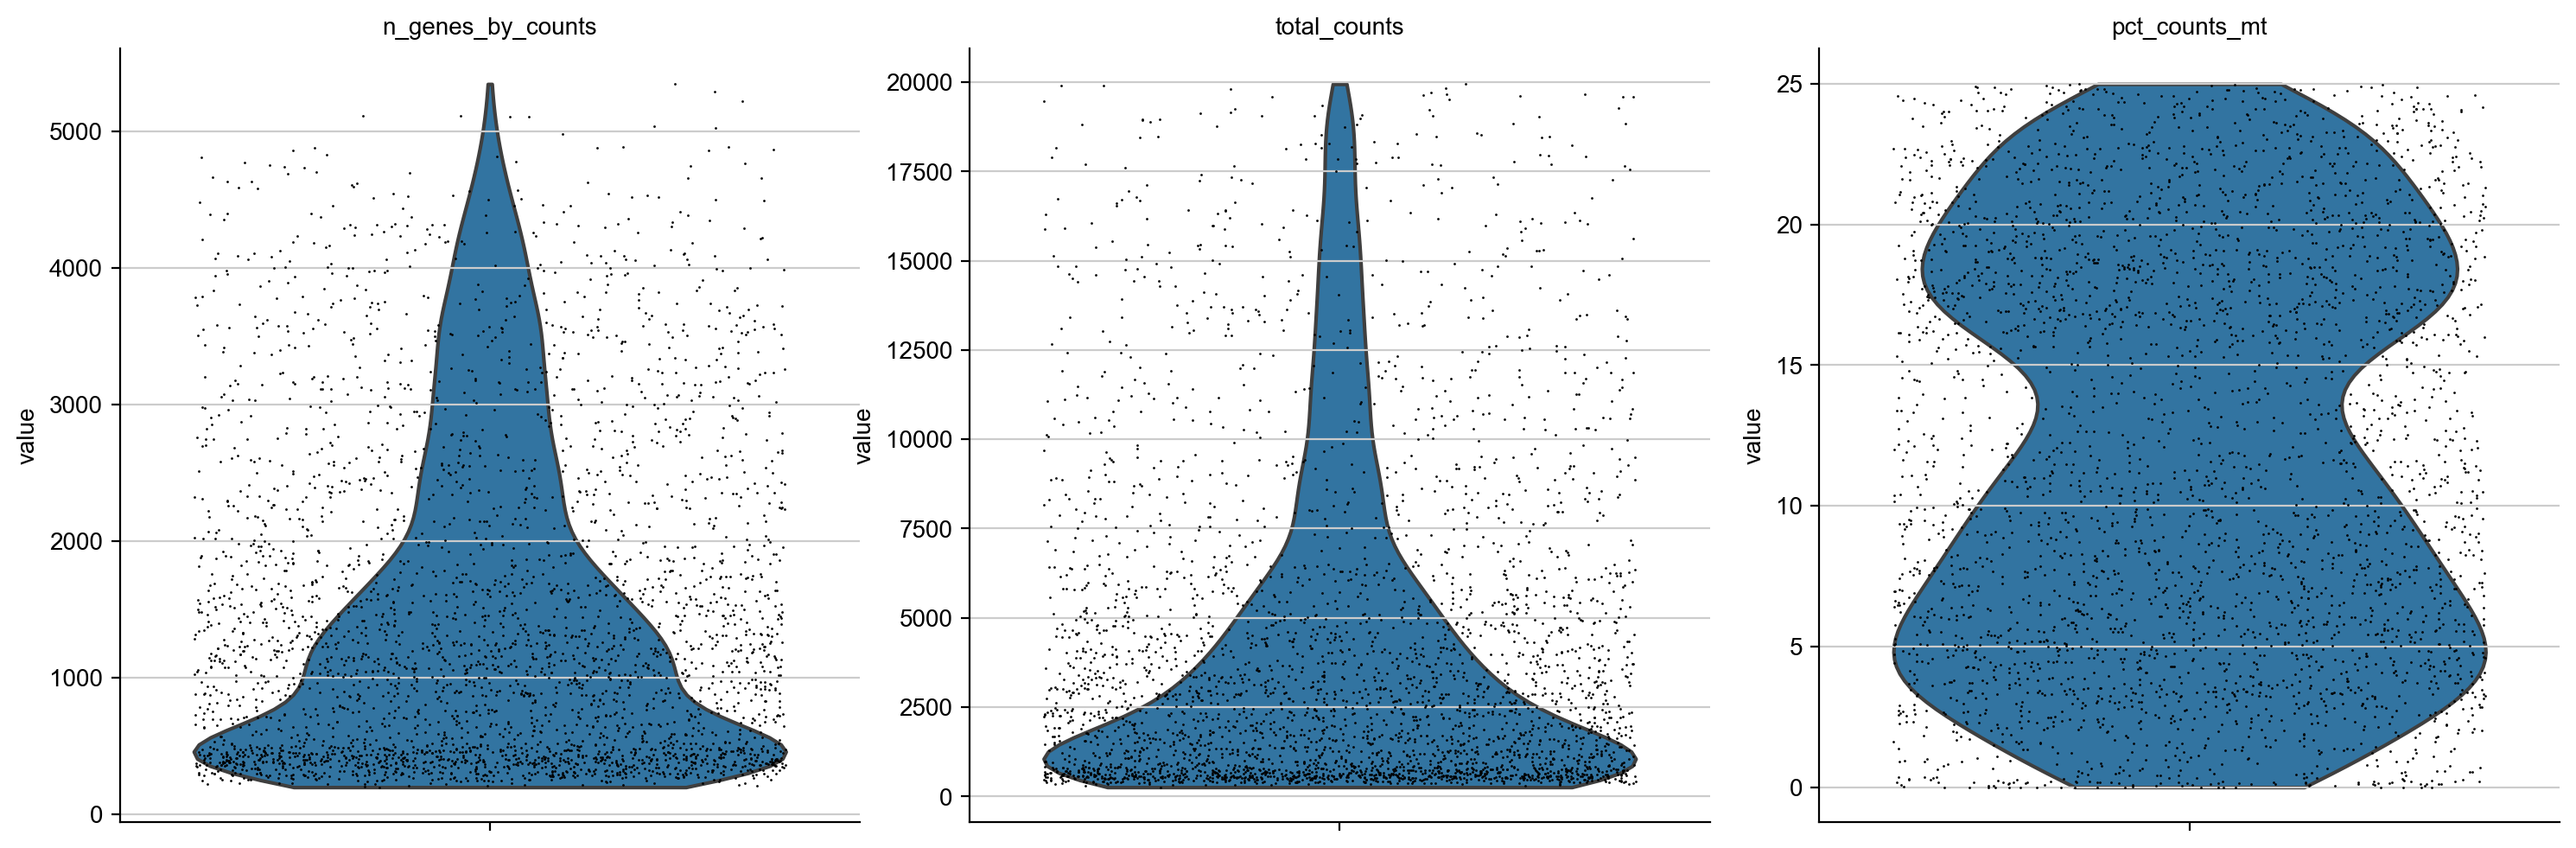

In [54]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [55]:
adata

View of AnnData object with n_obs × n_vars = 3379 × 18056
    obs: 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [56]:
#adata = adata[adata.obs["injury"]=="Day 0"]
#adata

In [57]:
resultsFileQC

'write/luadDost_QC.h5ad'

In [58]:
adata.write(resultsFileQC)

In [2]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 python-igraph==0.10.4 pynndescent==0.5.12


In [4]:
%matplotlib inline

In [5]:
writeDir = "write/"

fileName = "luadDost"

resultsFile = writeDir + fileName + '.h5ad'       # final output
resultsFileQC = writeDir + fileName + '_QC.h5ad'  # post QC (pre-analysis) 

In [6]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

In [126]:
adata = sc.read_h5ad(resultsFileQC)
adata

AnnData object with n_obs × n_vars = 3379 × 18056
    obs: 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [127]:
adata = adata[adata.obs.source=="1"]

In [128]:
sc.pp.normalize_total(adata,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [129]:
sc.pp.log1p(adata)

In [130]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2635


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


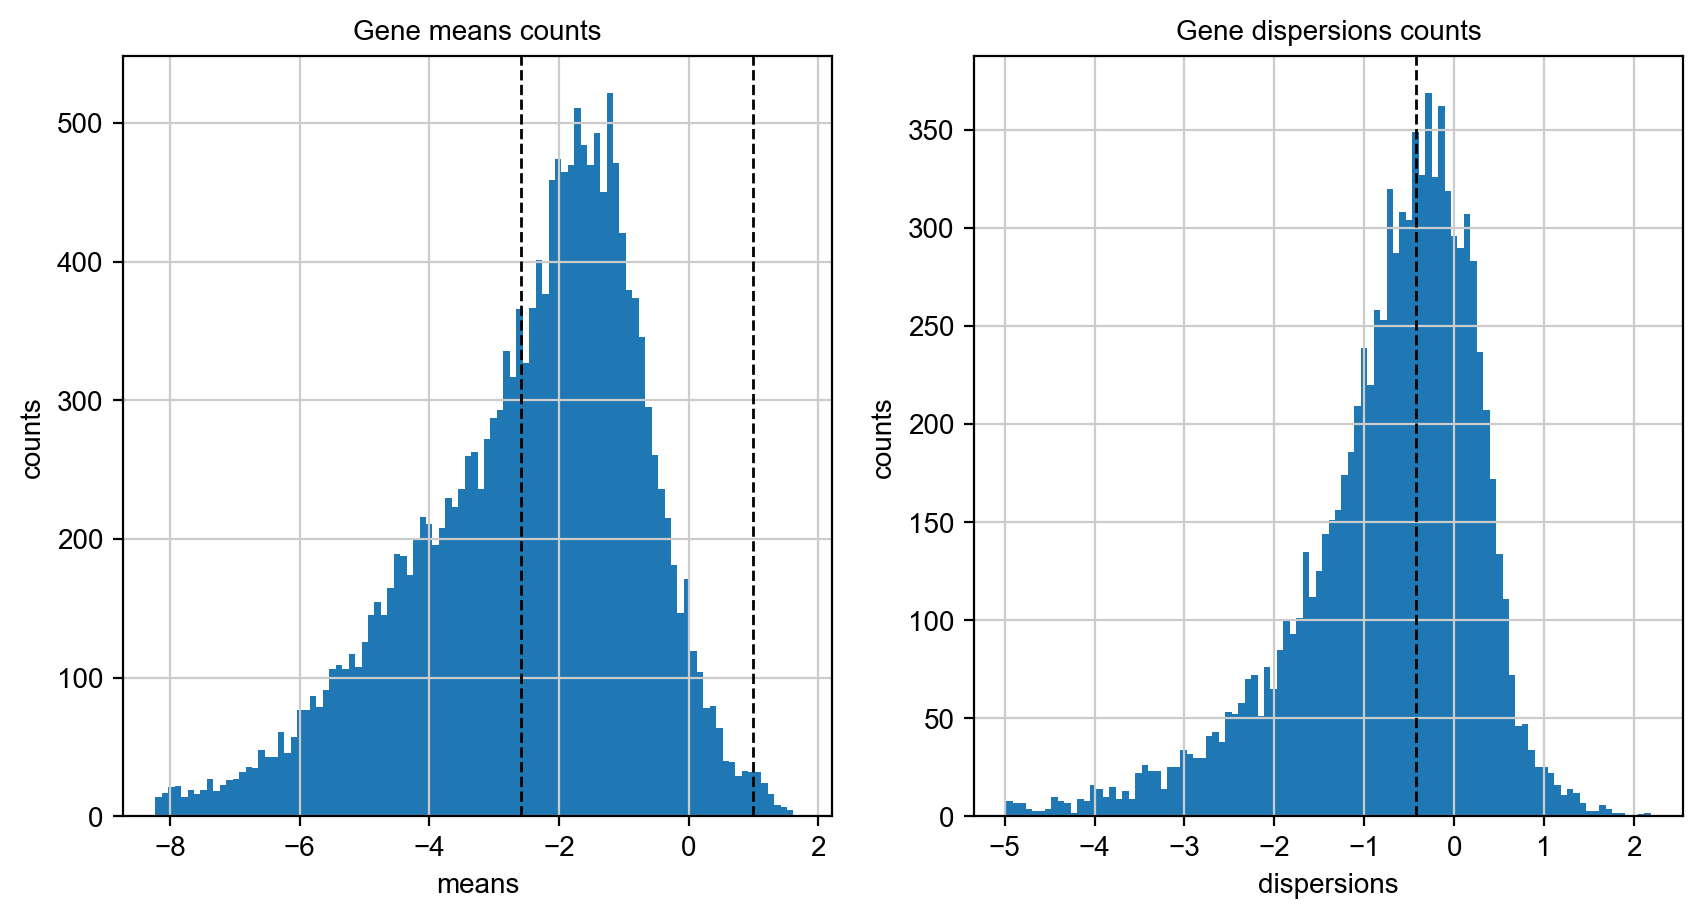

In [131]:
minMean = 0.075
maxMean = 2.7
minDisp = 0.65

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

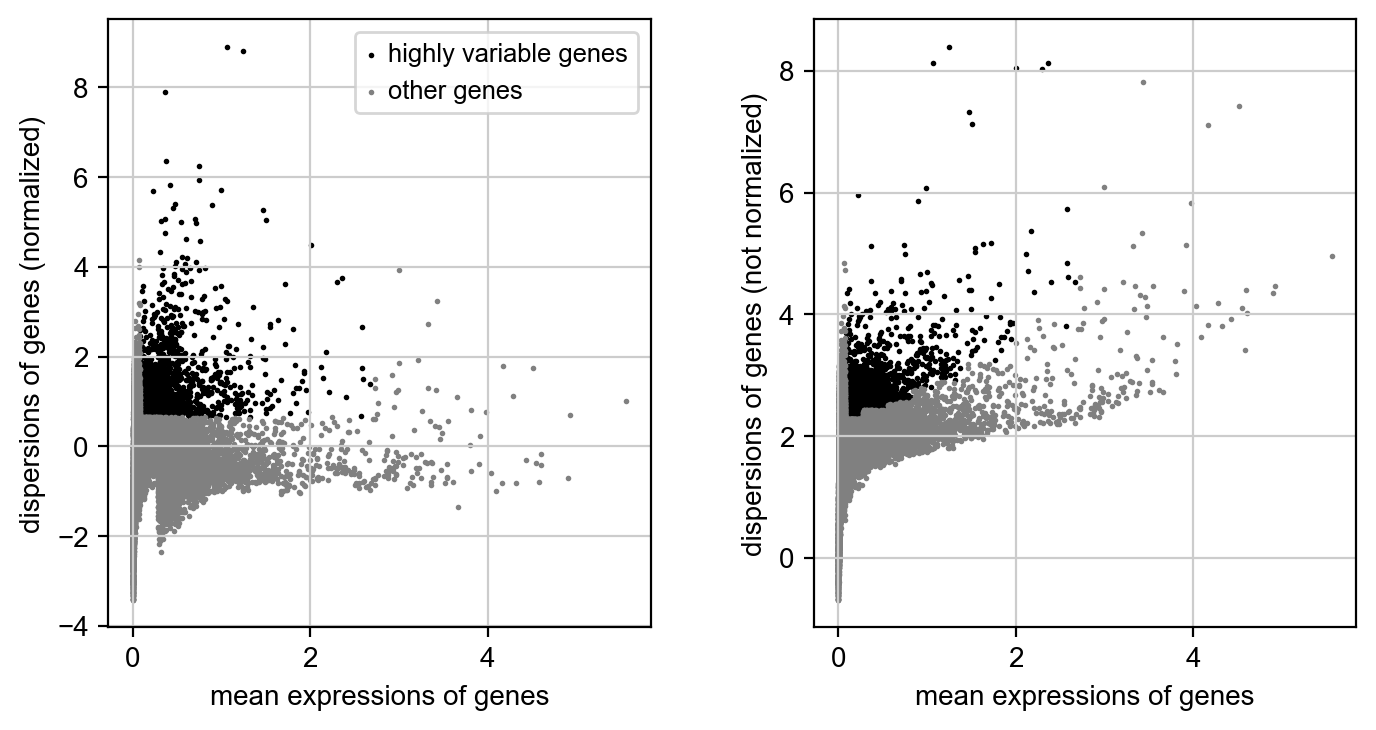

In [132]:
sc.pl.highly_variable_genes(adata)

In [133]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [134]:
adata.raw = adata

In [135]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [136]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [137]:
#sc.pp.scale(adata, max_value=10)

In [138]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


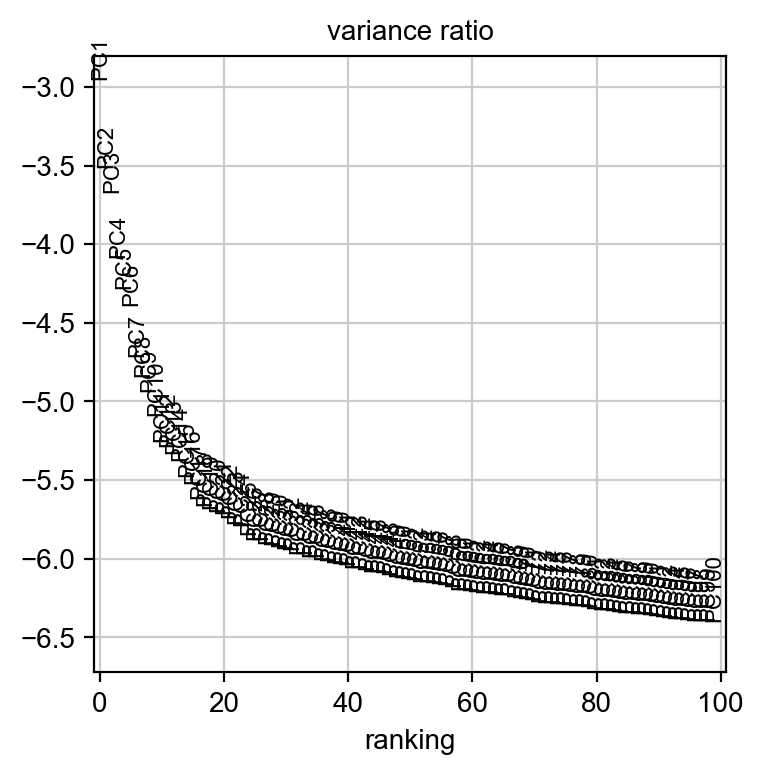

In [139]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

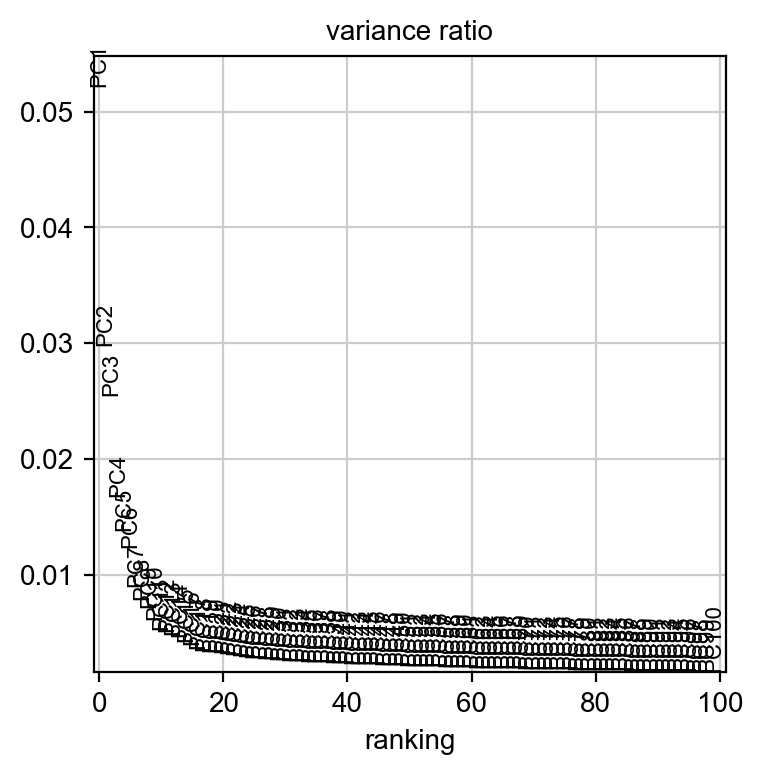

In [140]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [141]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [142]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


In [143]:
sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [144]:
adata

AnnData object with n_obs × n_vars = 1878 × 2634
    obs: 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

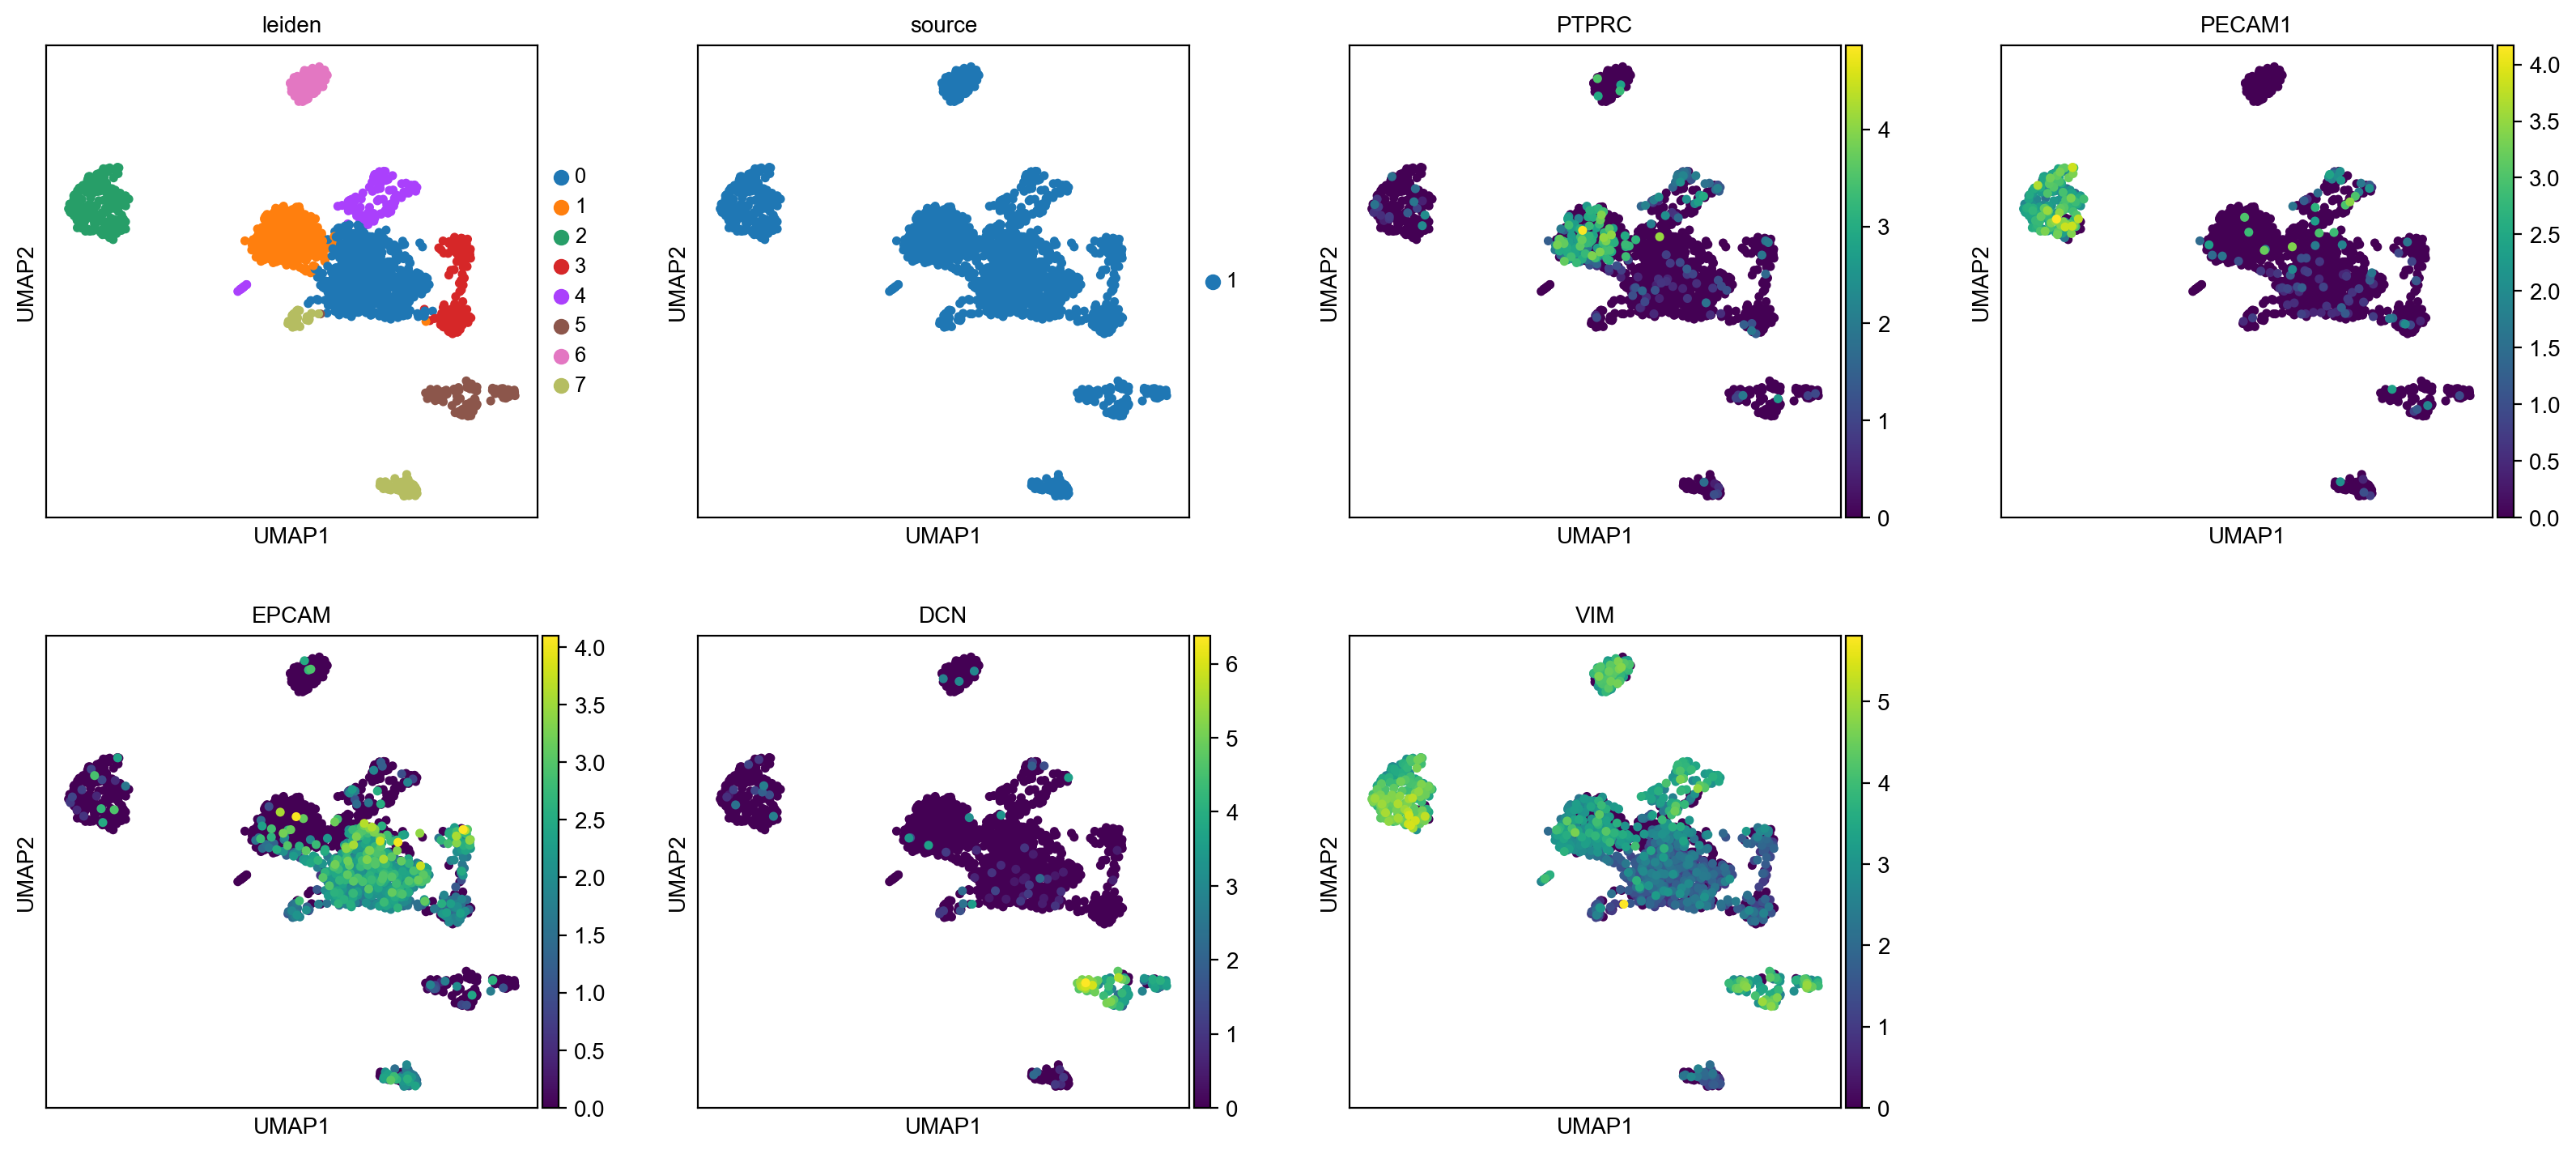

In [145]:
sc.pl.umap(adata, color=["leiden","source","PTPRC","PECAM1","EPCAM","DCN","VIM"],ncols=4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

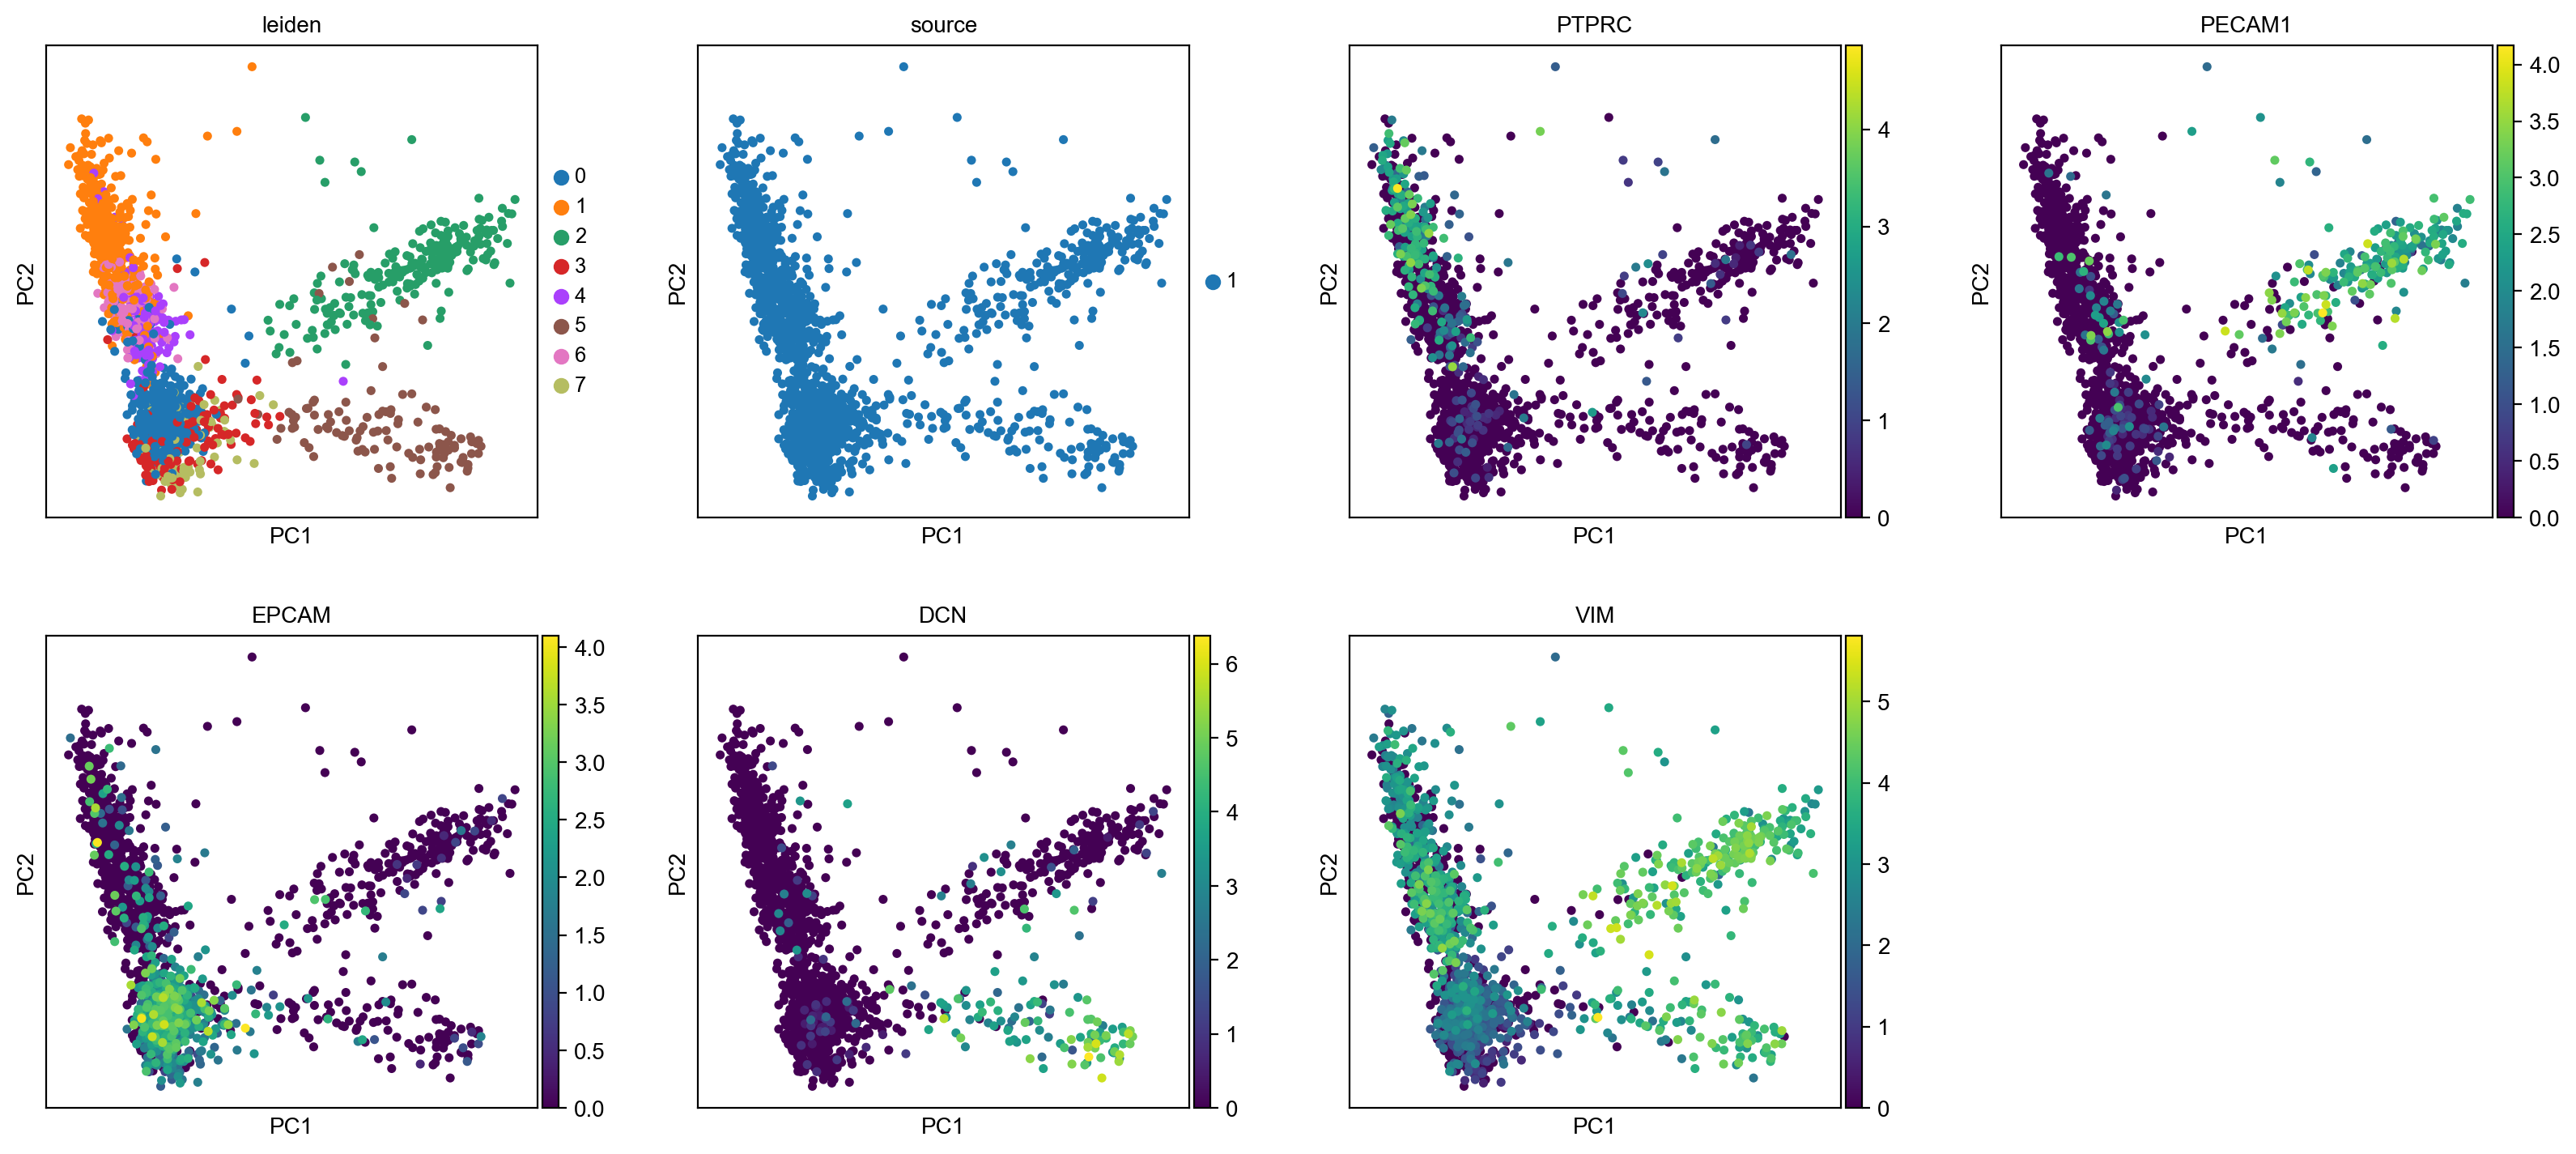

In [146]:
sc.pl.pca(adata, color=["leiden","source","PTPRC","PECAM1","EPCAM","DCN","VIM"],ncols=4)

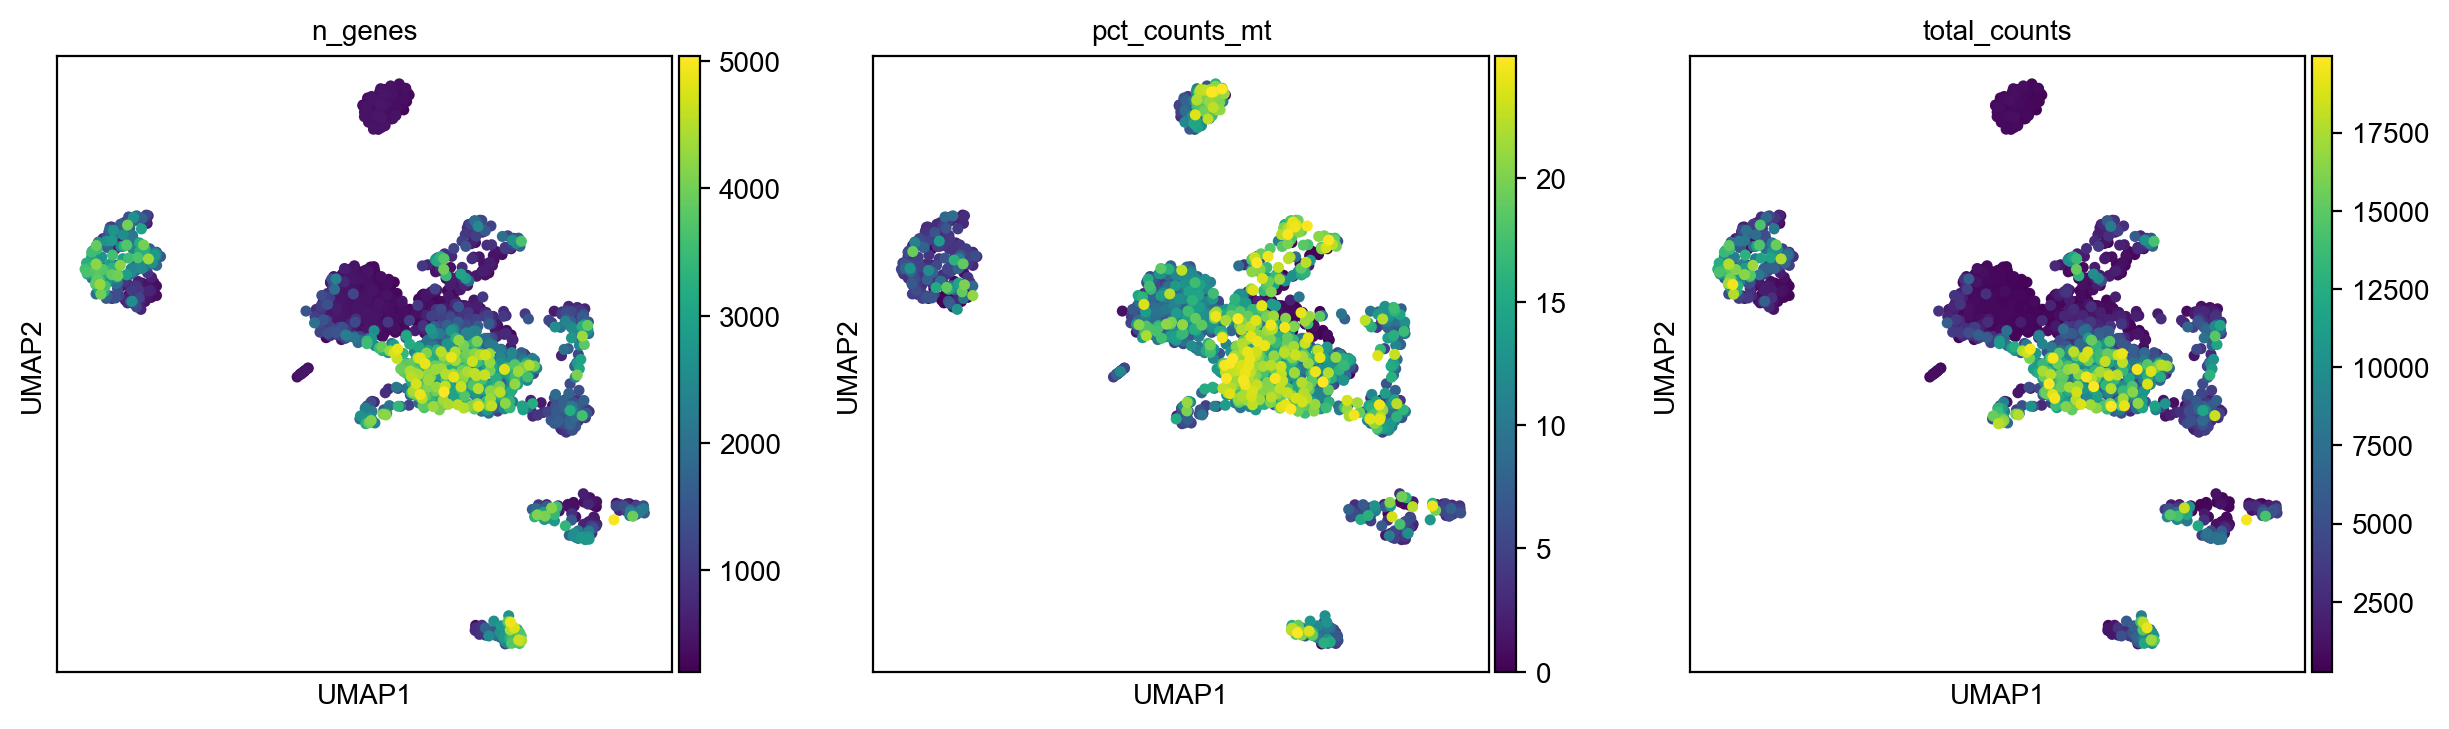

In [147]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:843: 

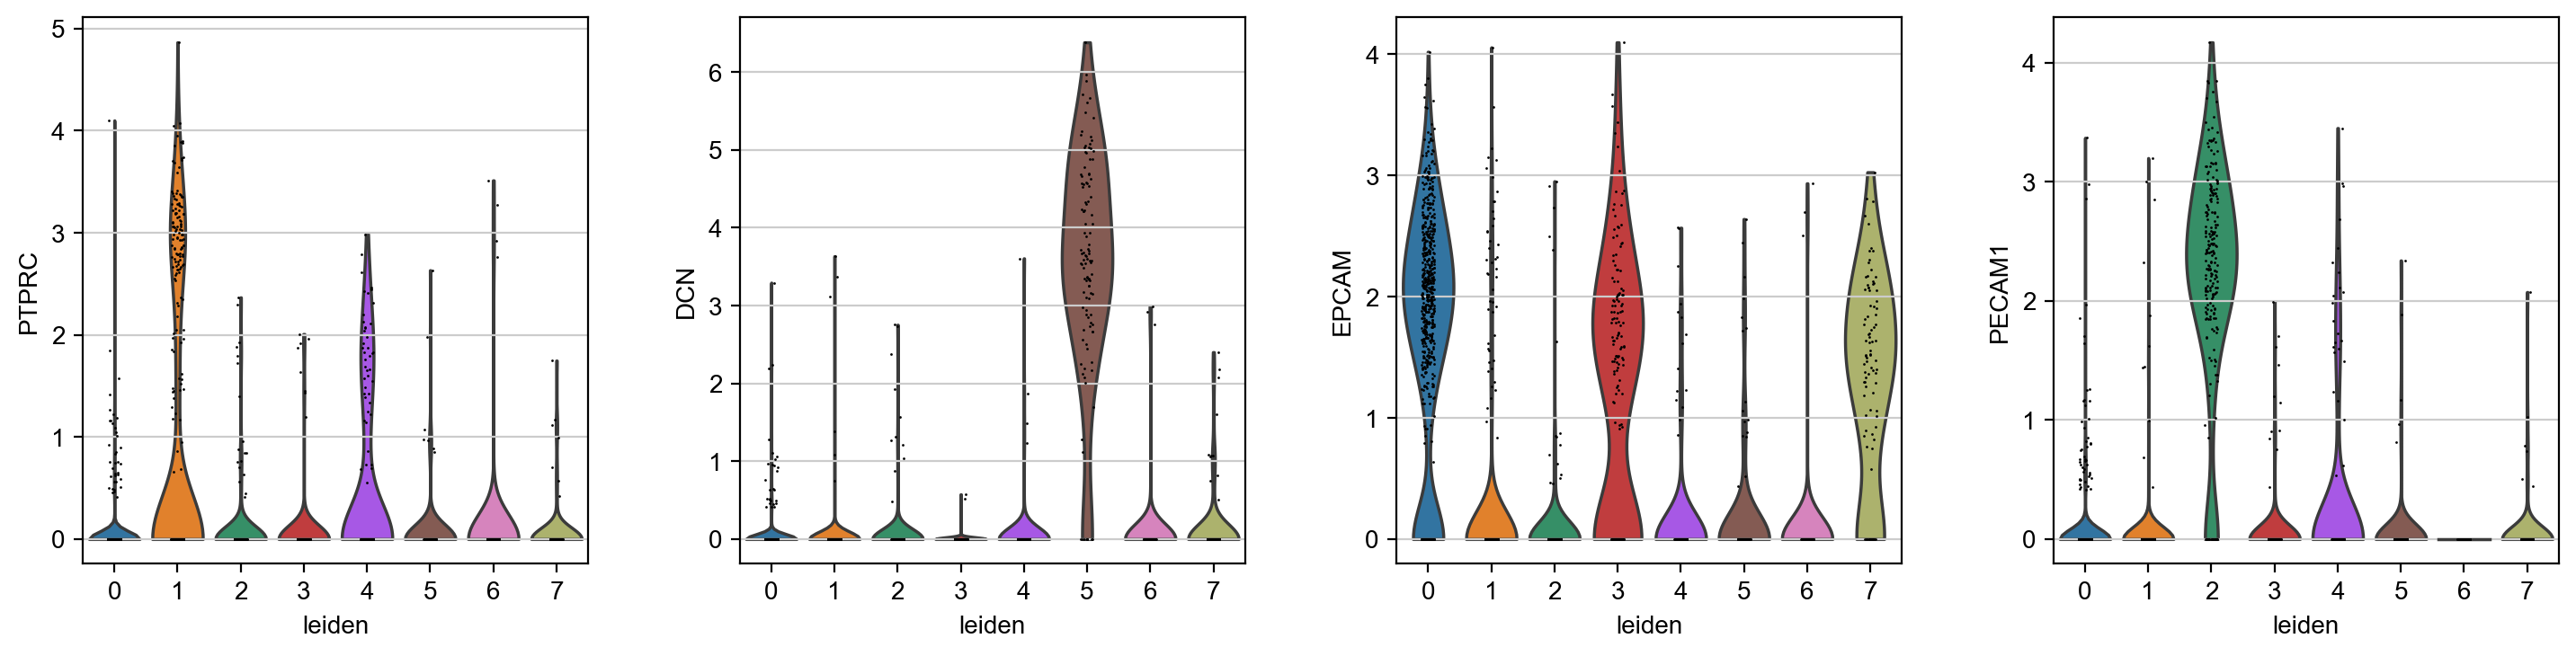

In [148]:
sc.pl.violin(adata, ["PTPRC","DCN","EPCAM","PECAM1"], groupby="leiden")

In [149]:
label = []
for l in adata.obs.leiden:
    if l in ["0","3"]:
        label.append("tumor")
    elif l in ["2","7"]:
        label.append("epith")
    elif l in ["5","6"]:
        label.append("fibr")
    else:
        label.append("imm")

In [150]:
adata.obs["label"] = label

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

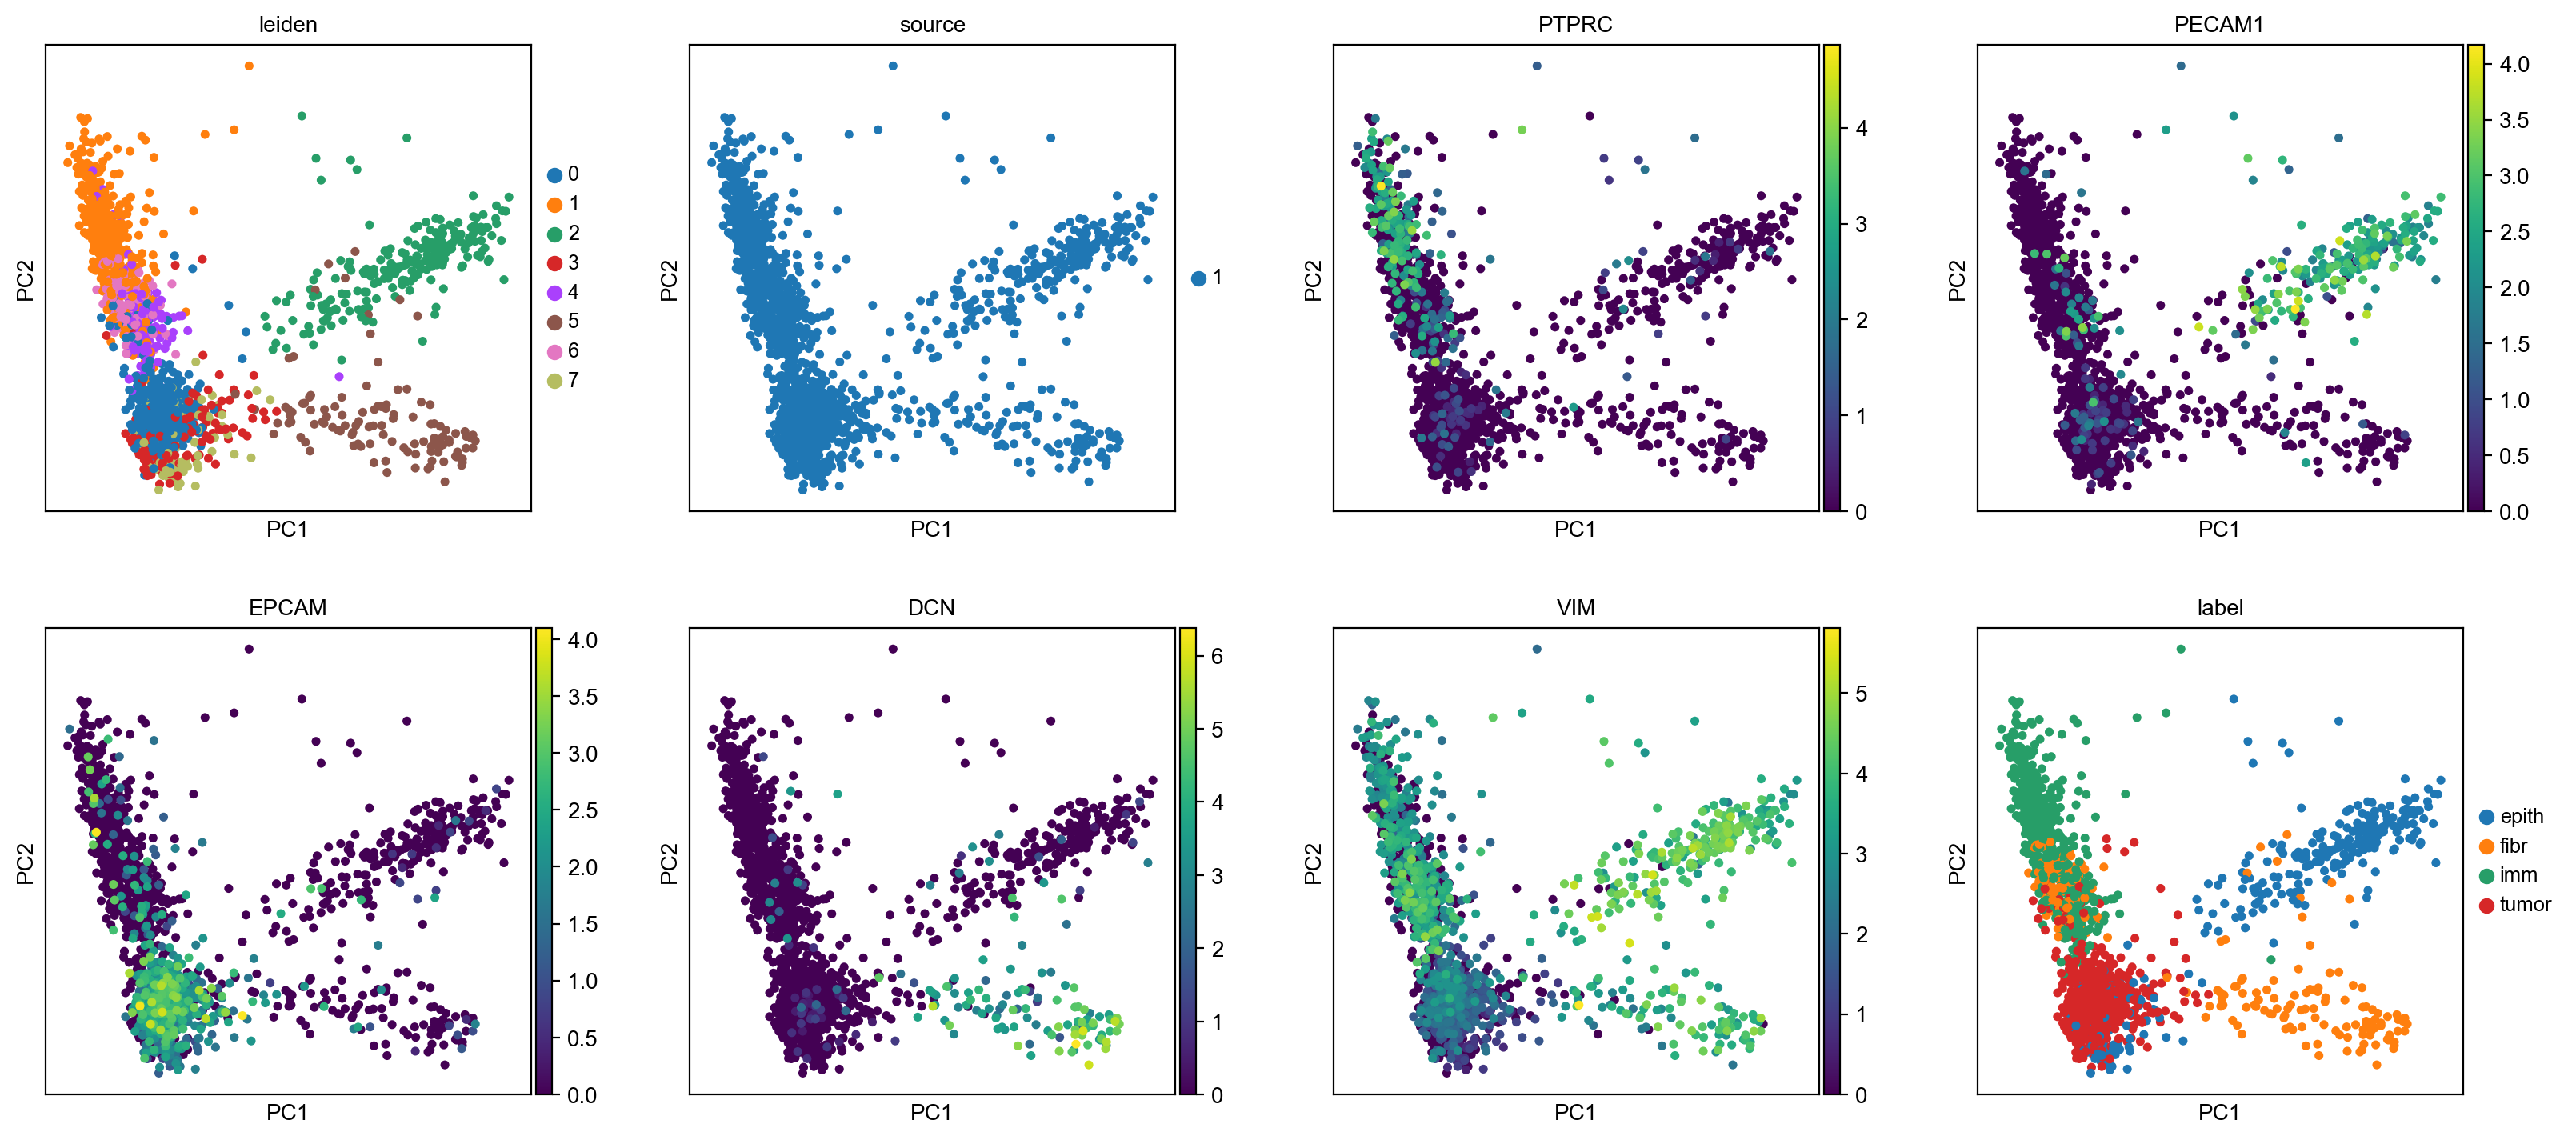

In [151]:
sc.pl.pca(adata, color=["leiden","source","PTPRC","PECAM1","EPCAM","DCN","VIM","label"],ncols=4)

/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

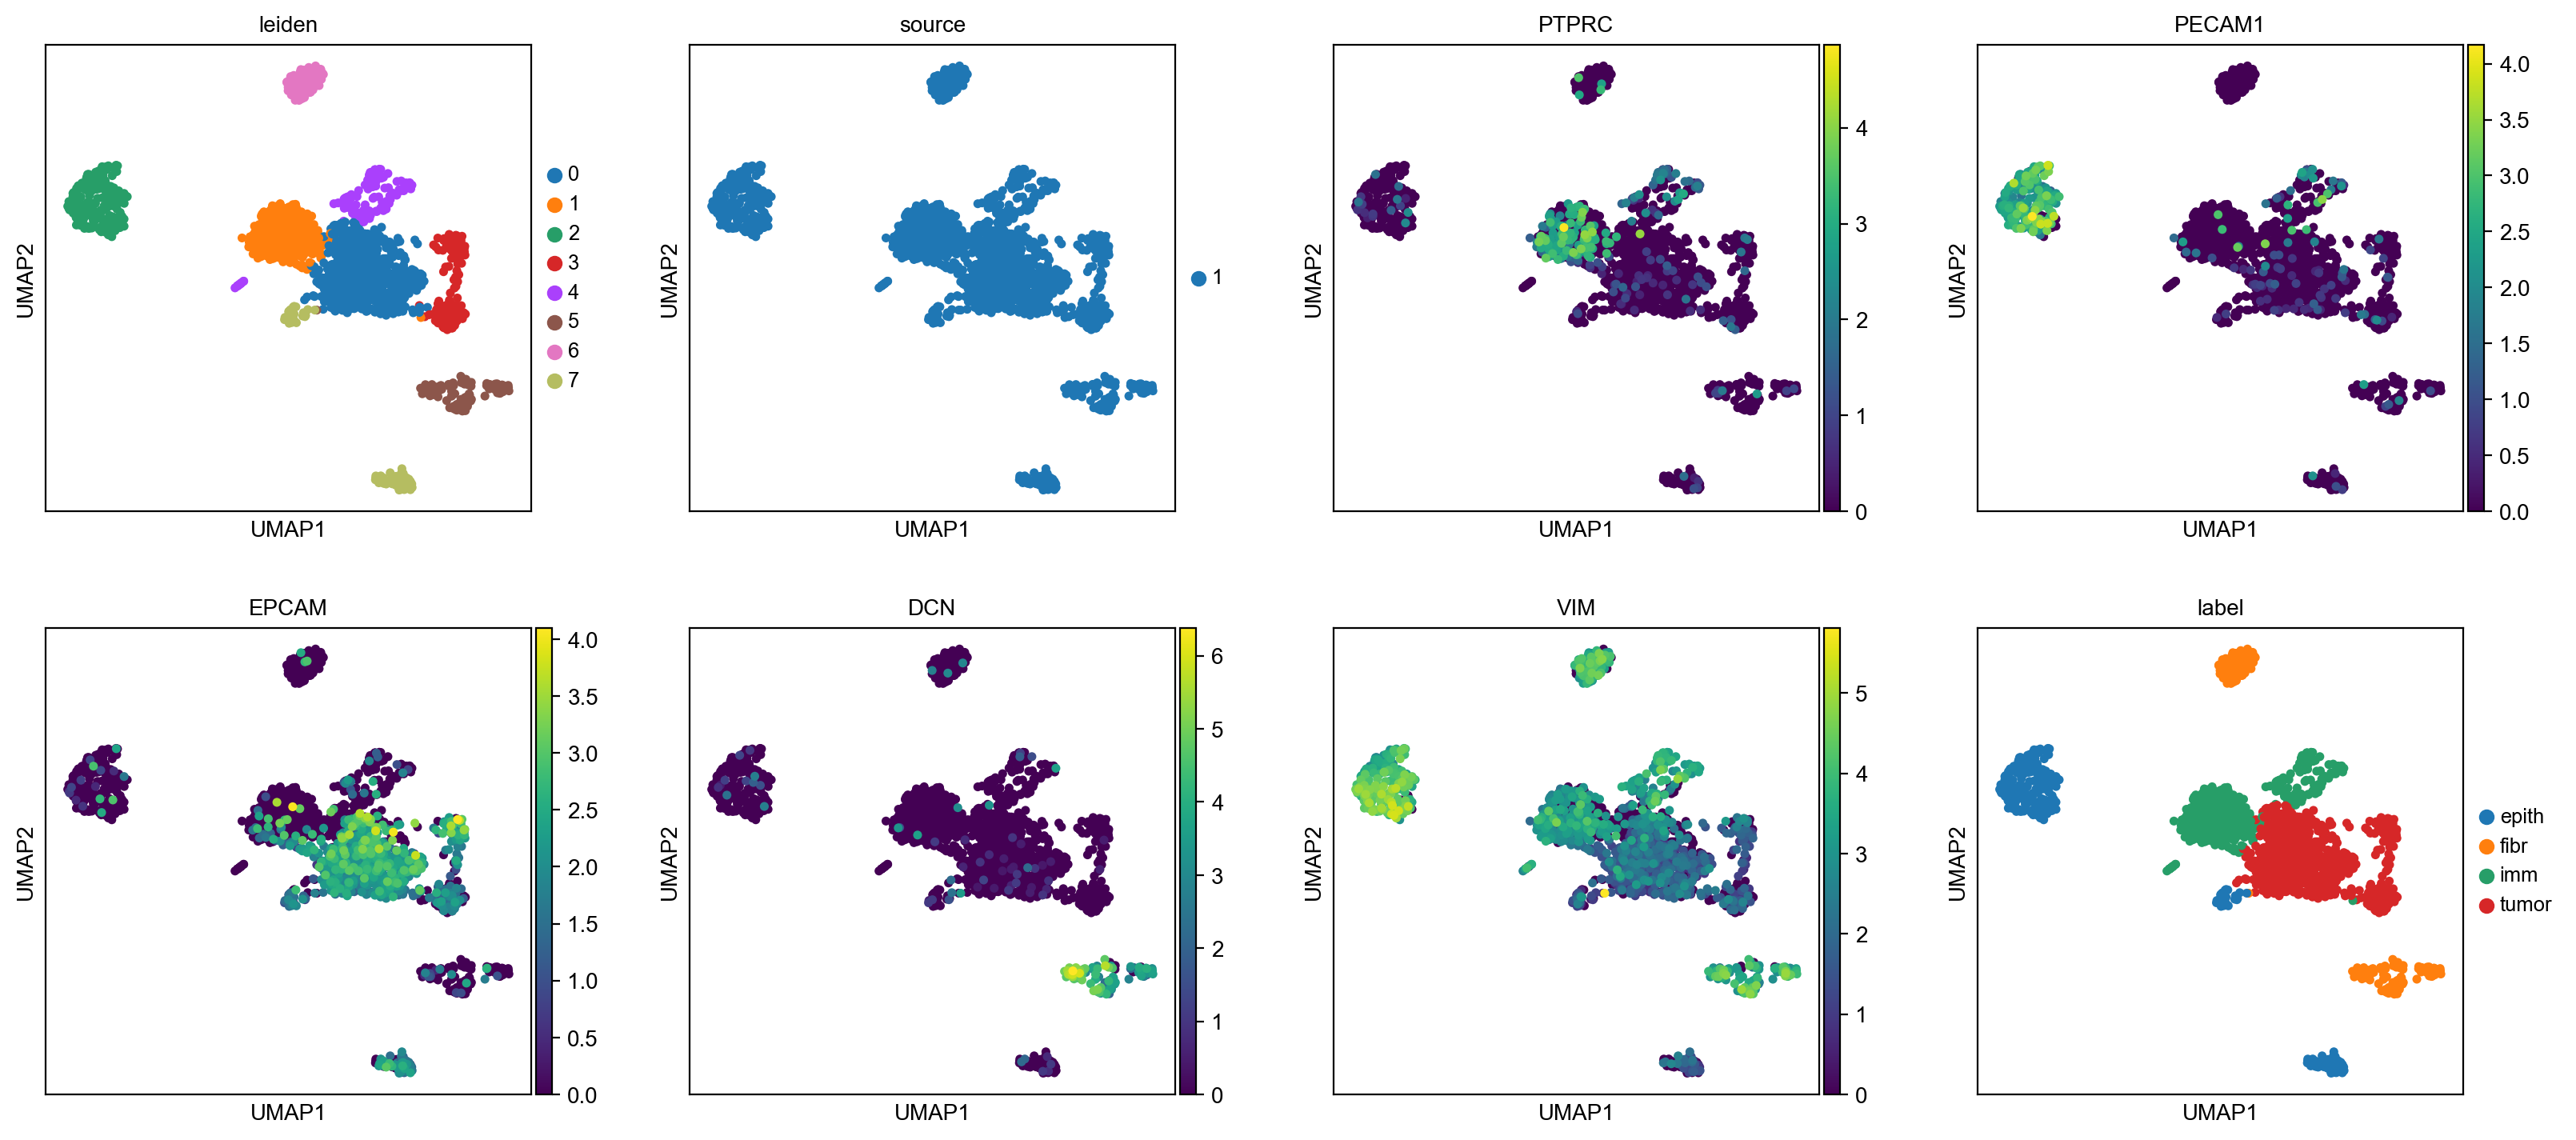

In [152]:
sc.pl.umap(adata, color=["leiden","source","PTPRC","PECAM1","EPCAM","DCN","VIM","label"],ncols=4)

In [153]:
adata = adata.raw.to_adata()

In [154]:
adata = adata[[l =="tumor" for l in adata.obs.label]]

In [155]:
sc.pp.highly_variable_genes(adata)#, flavor = "seurat", n_top_genes=2000)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2135


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


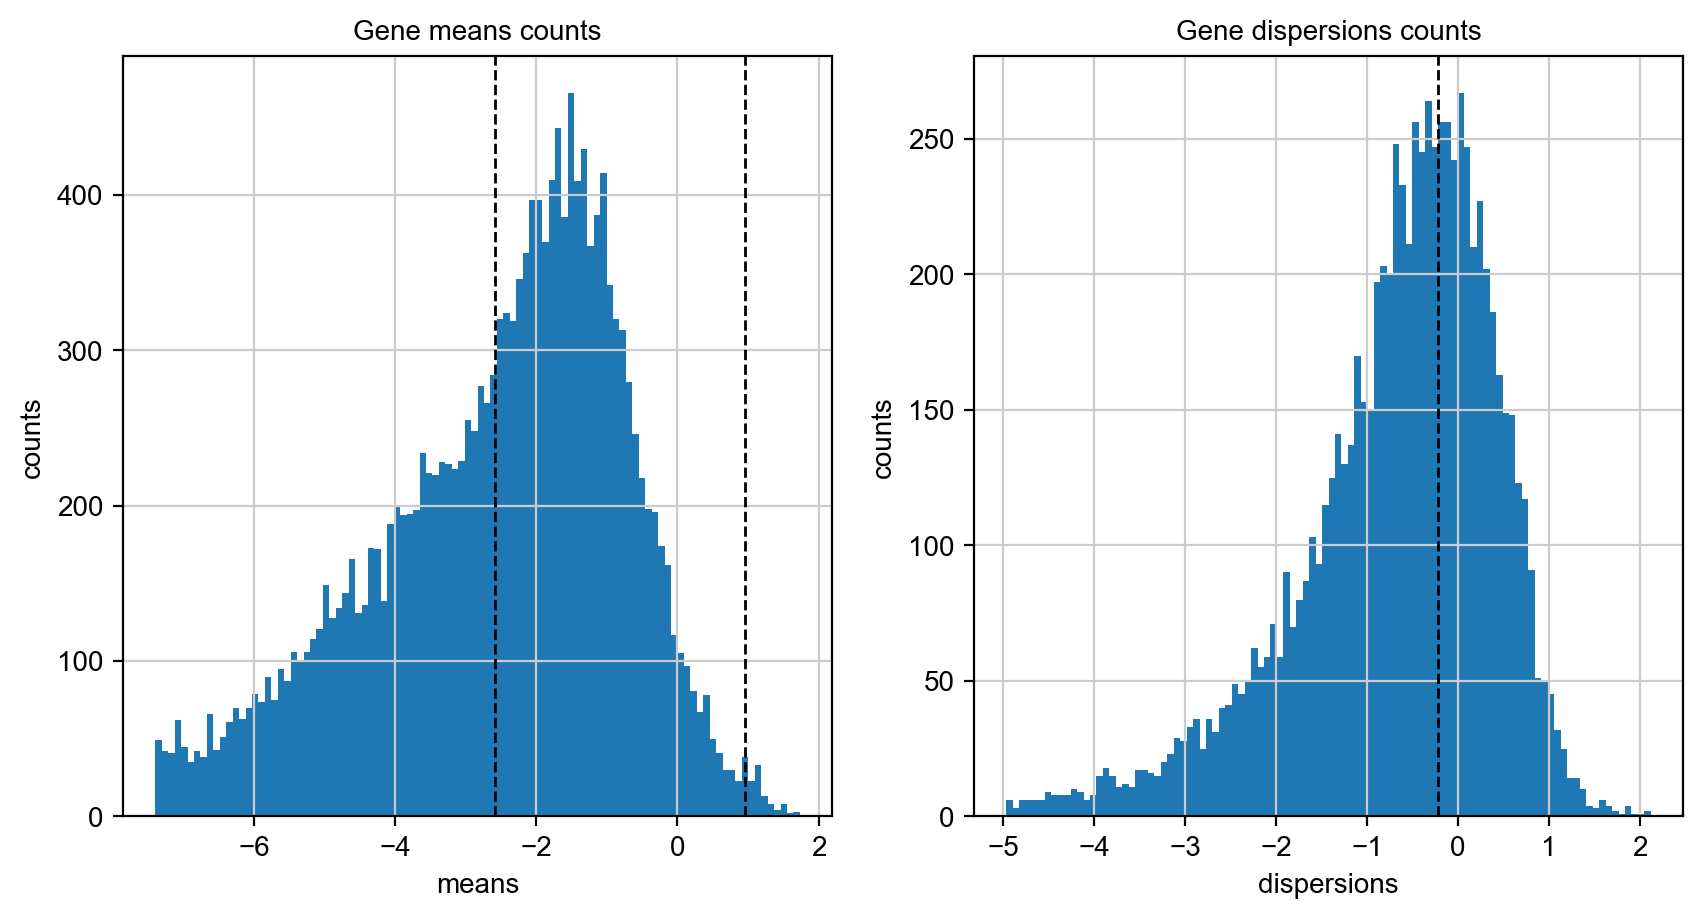

In [156]:
minMean = 0.075
maxMean = 2.6
minDisp = 0.8

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-5)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean)
print(sum(adata.var.highly_variable))

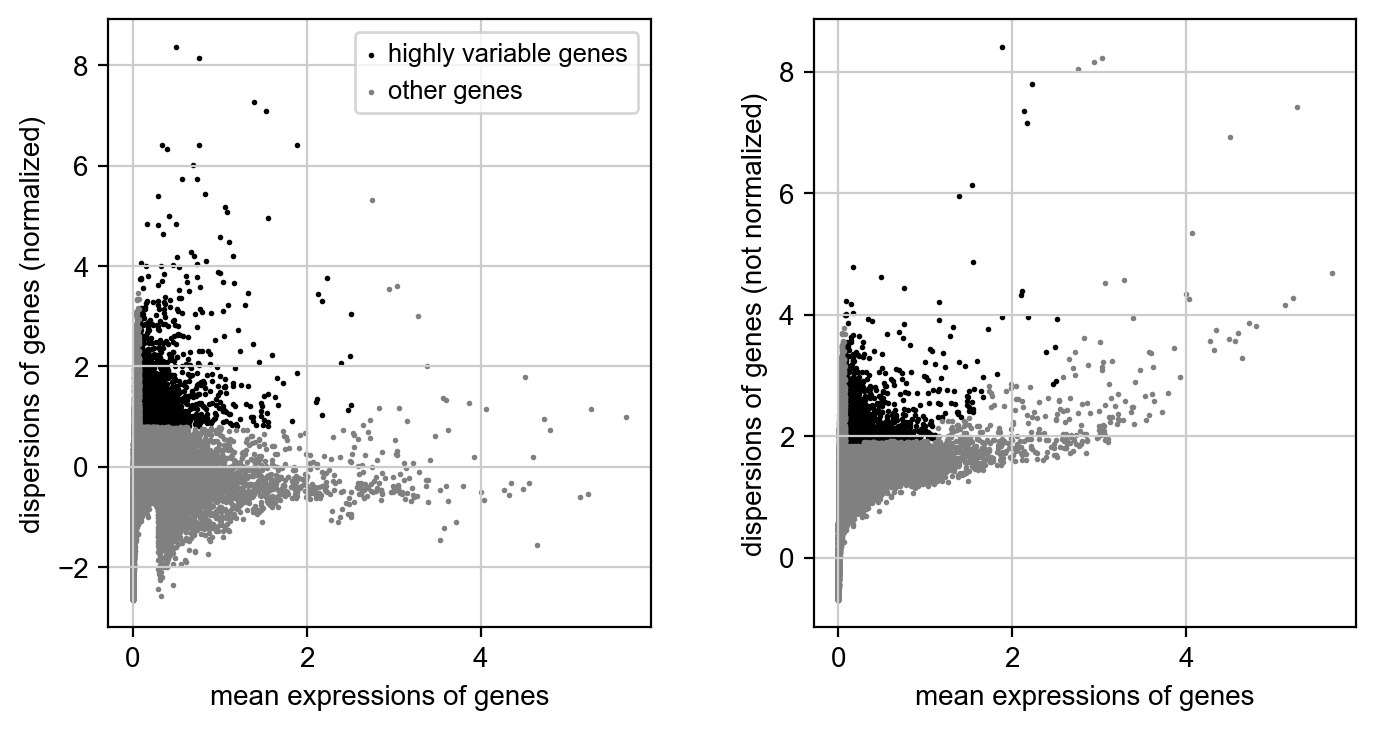

In [157]:
sc.pl.highly_variable_genes(adata)

In [158]:
#for inGene in adata.var[-8:].index.tolist():
#    adata.var.loc[inGene,"highly_variable"] = False

In [159]:
adata.raw = adata

In [160]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [161]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [162]:
#sc.pp.scale(adata, max_value=10)

In [163]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


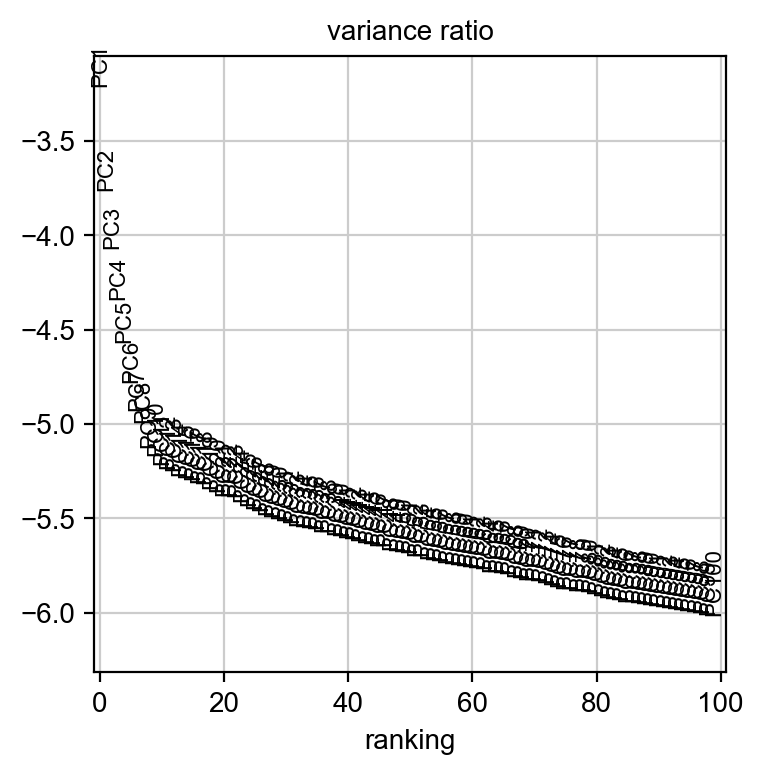

In [164]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

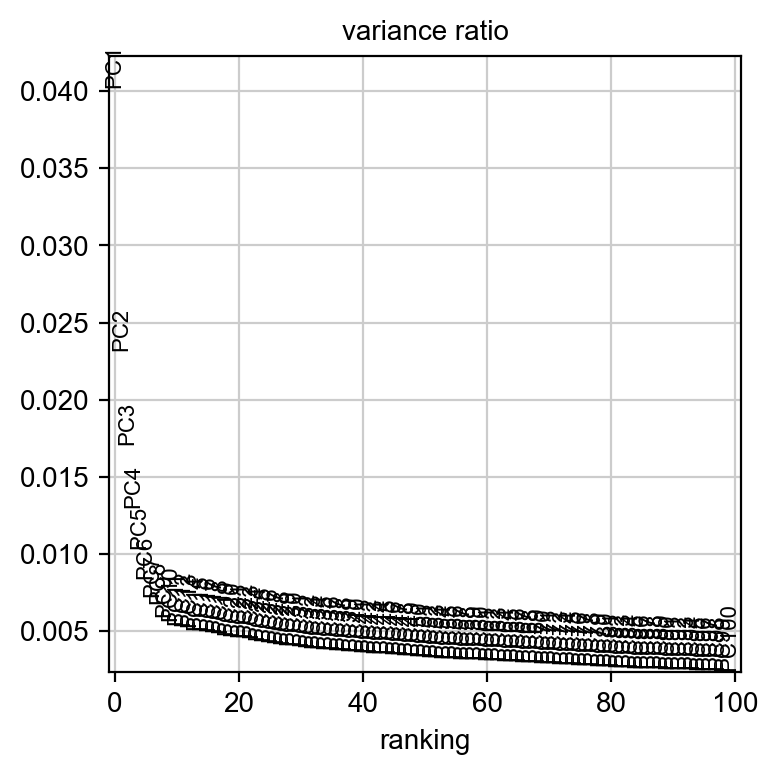

In [165]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

In [166]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [167]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [168]:
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

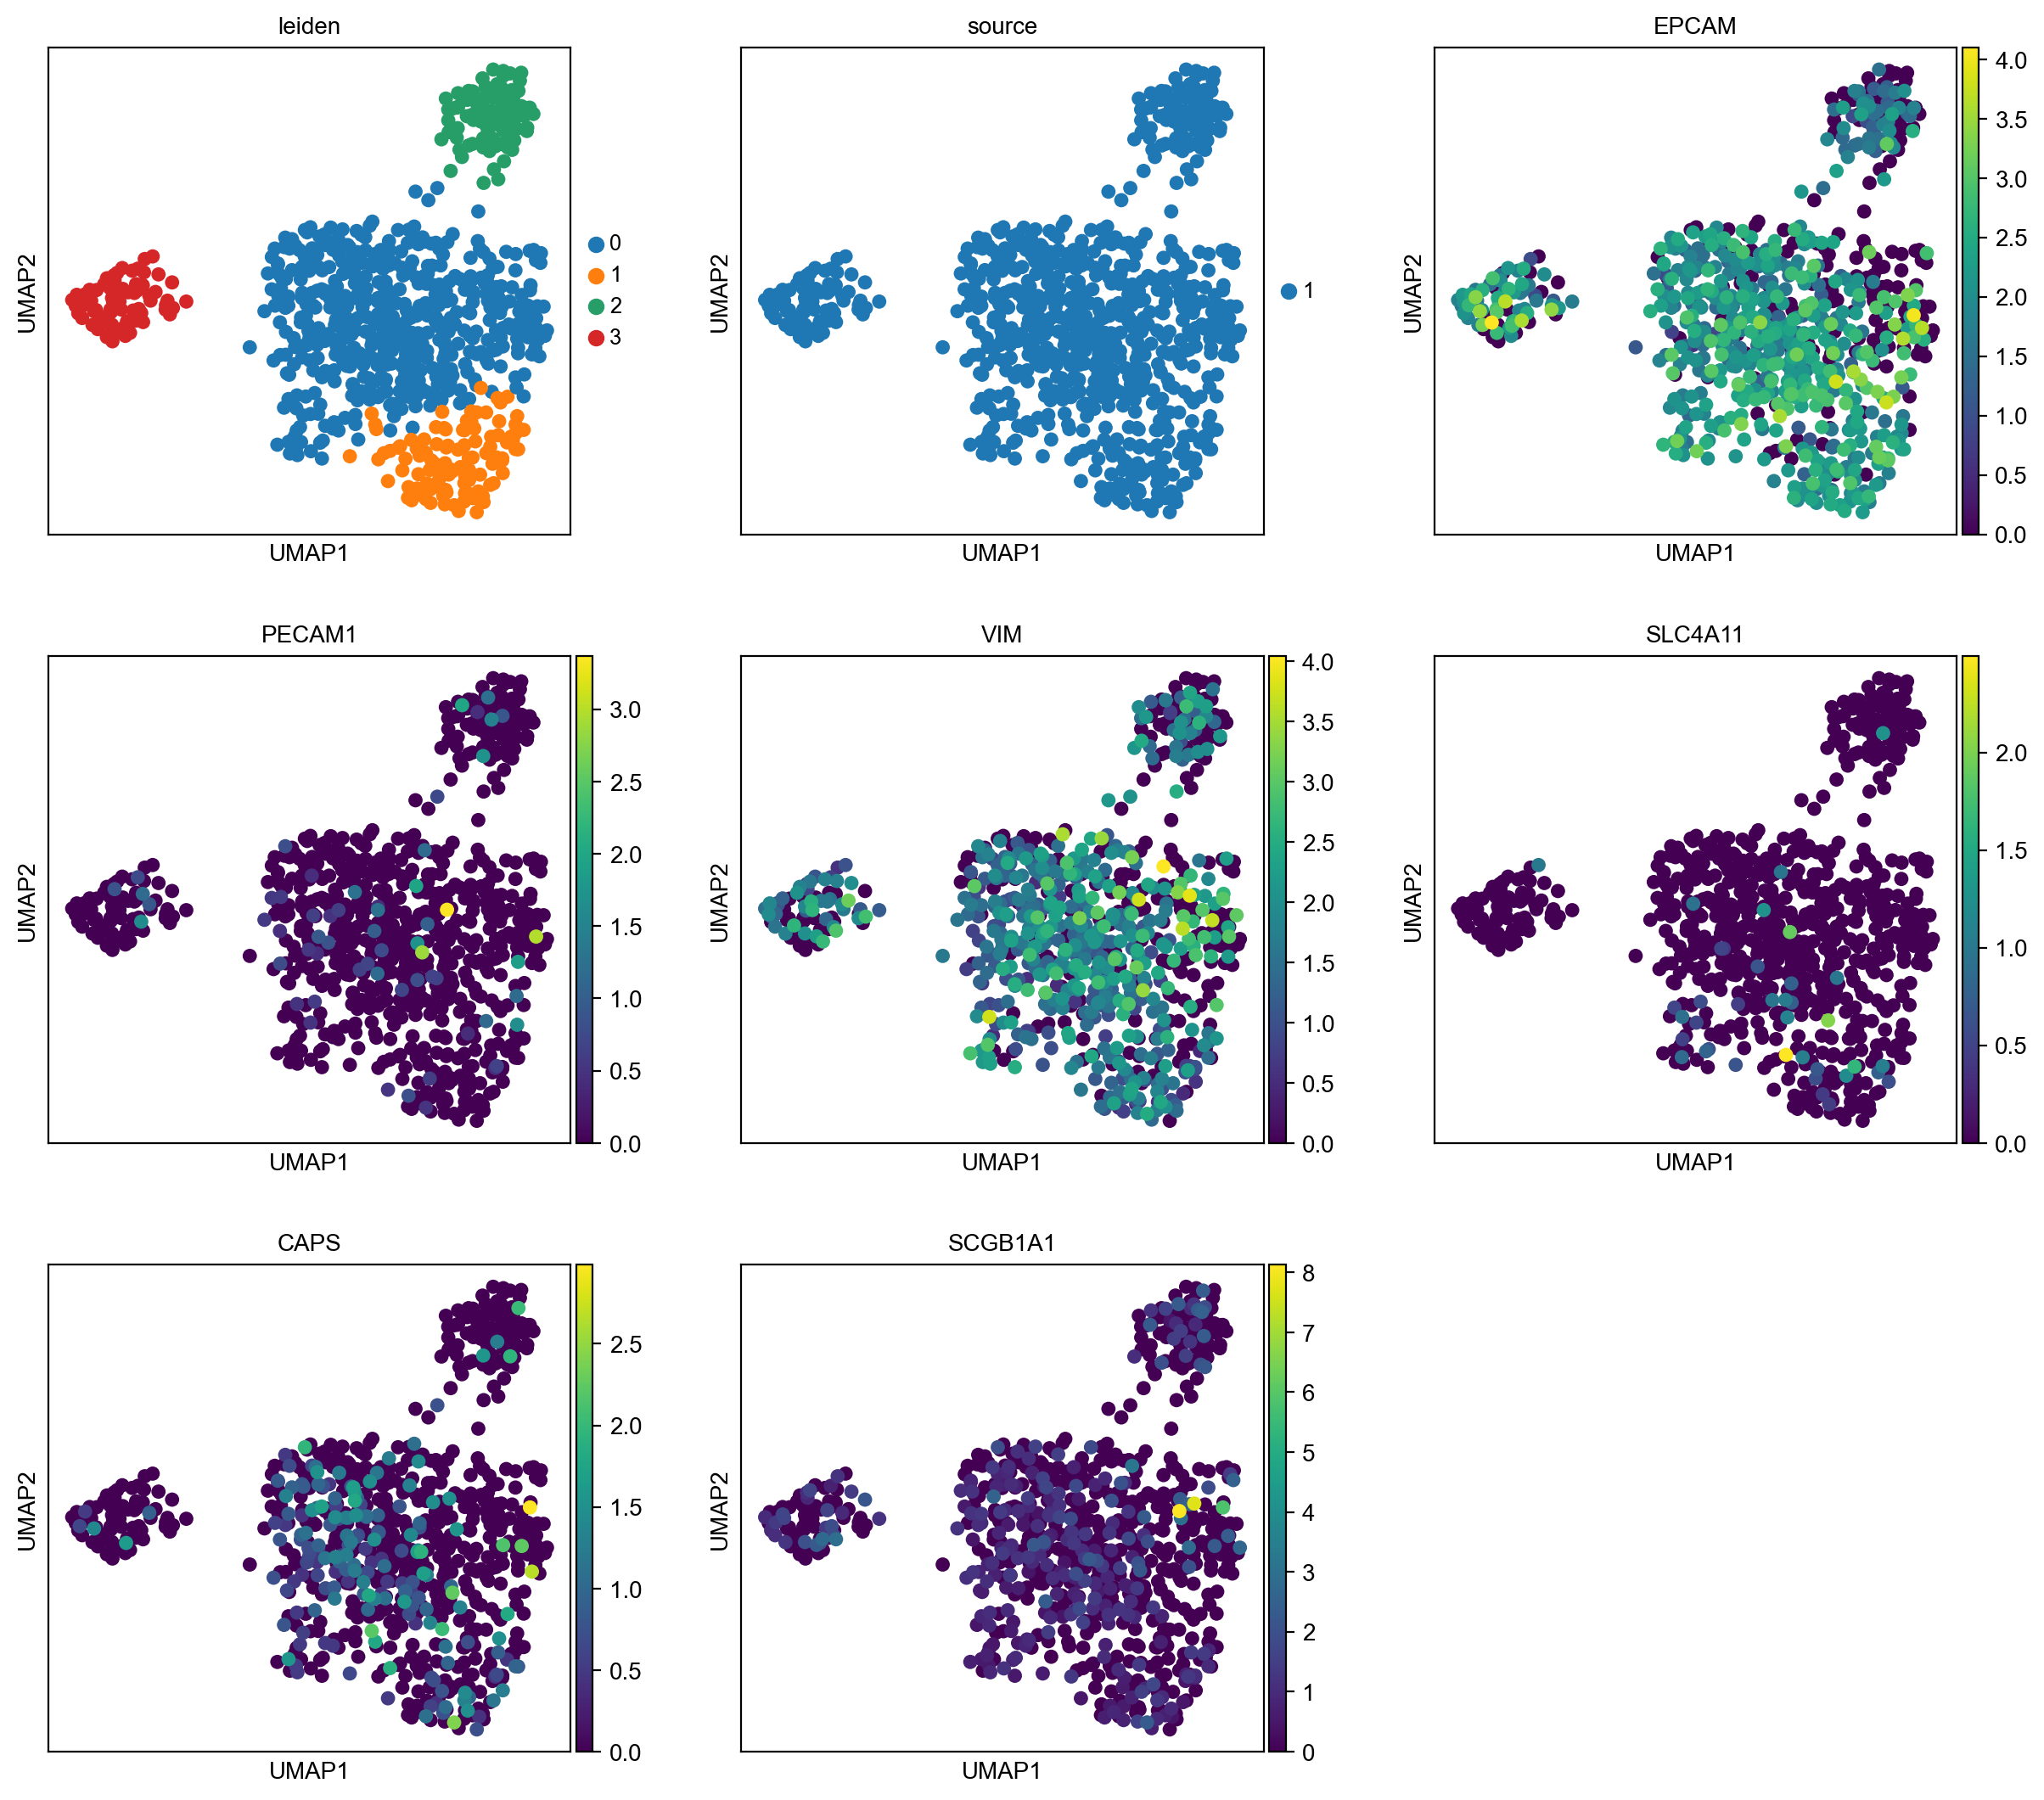

In [169]:
sc.pl.umap(adata, color=["leiden","source","EPCAM","PECAM1","VIM","SLC4A11","CAPS","SCGB1A1"],ncols=3)

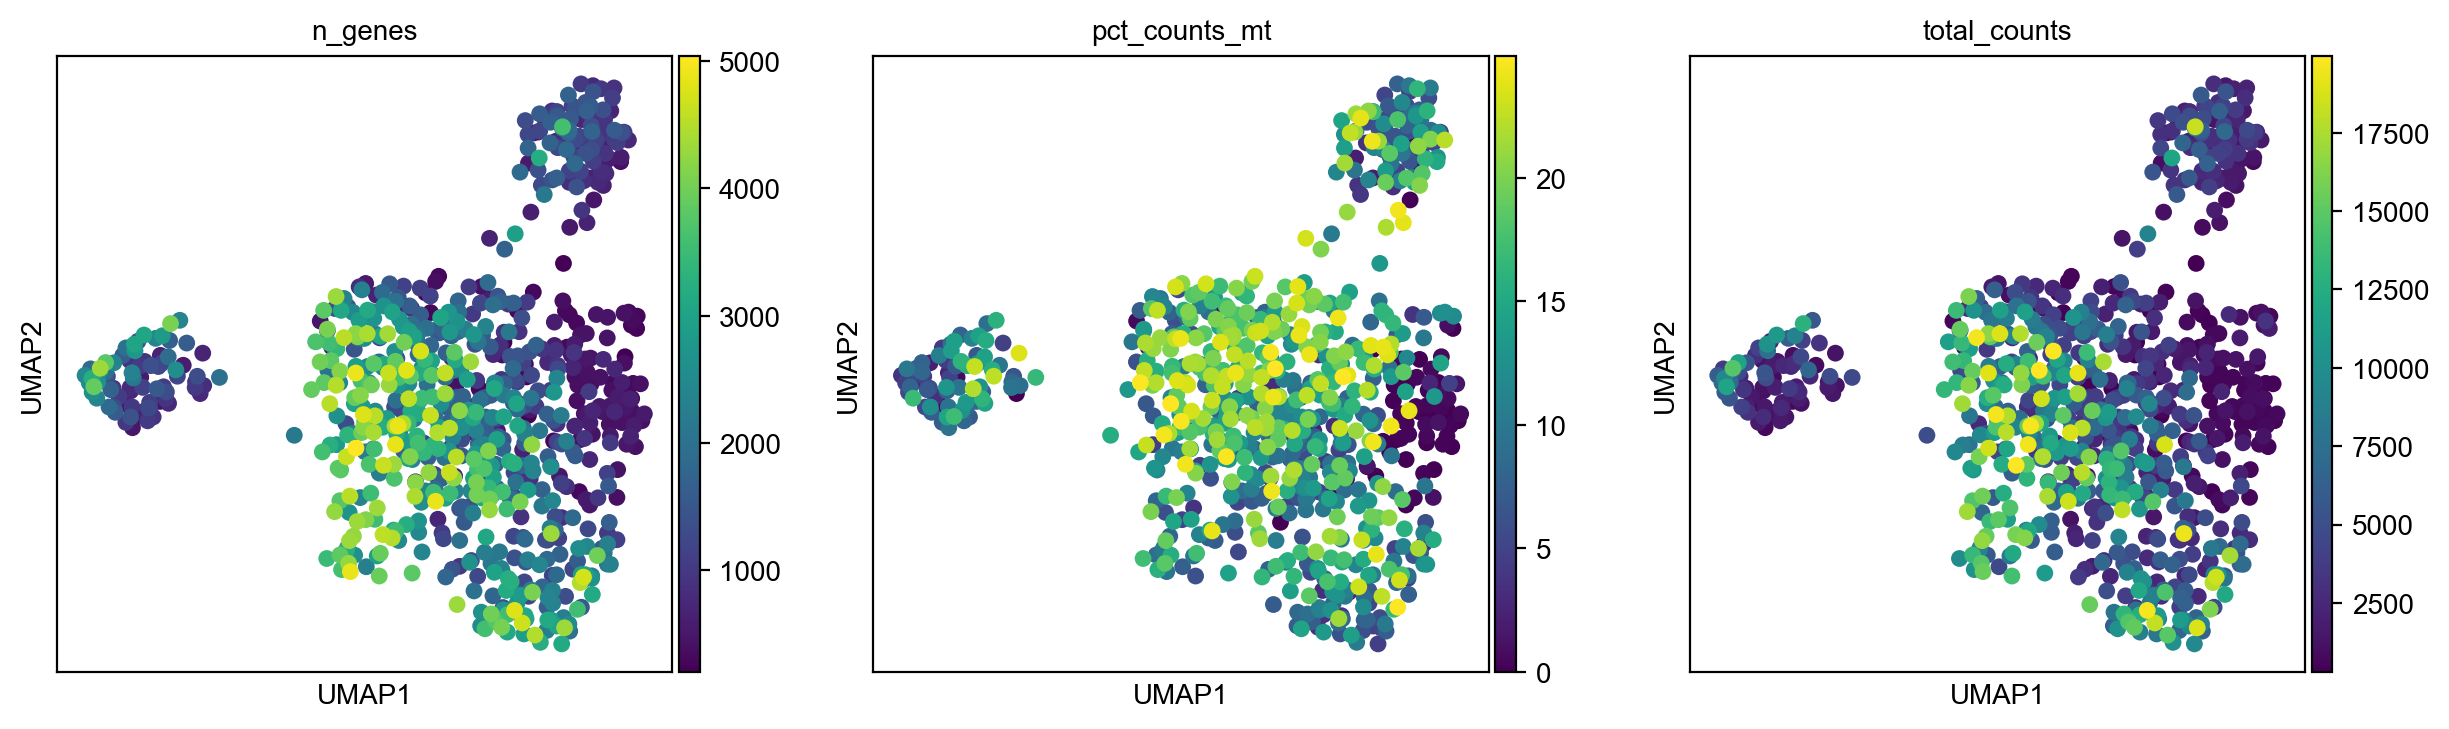

In [170]:
sc.pl.umap(adata, color=["n_genes","pct_counts_mt","total_counts"])

In [171]:
adata.uns['log1p']['base']=None

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


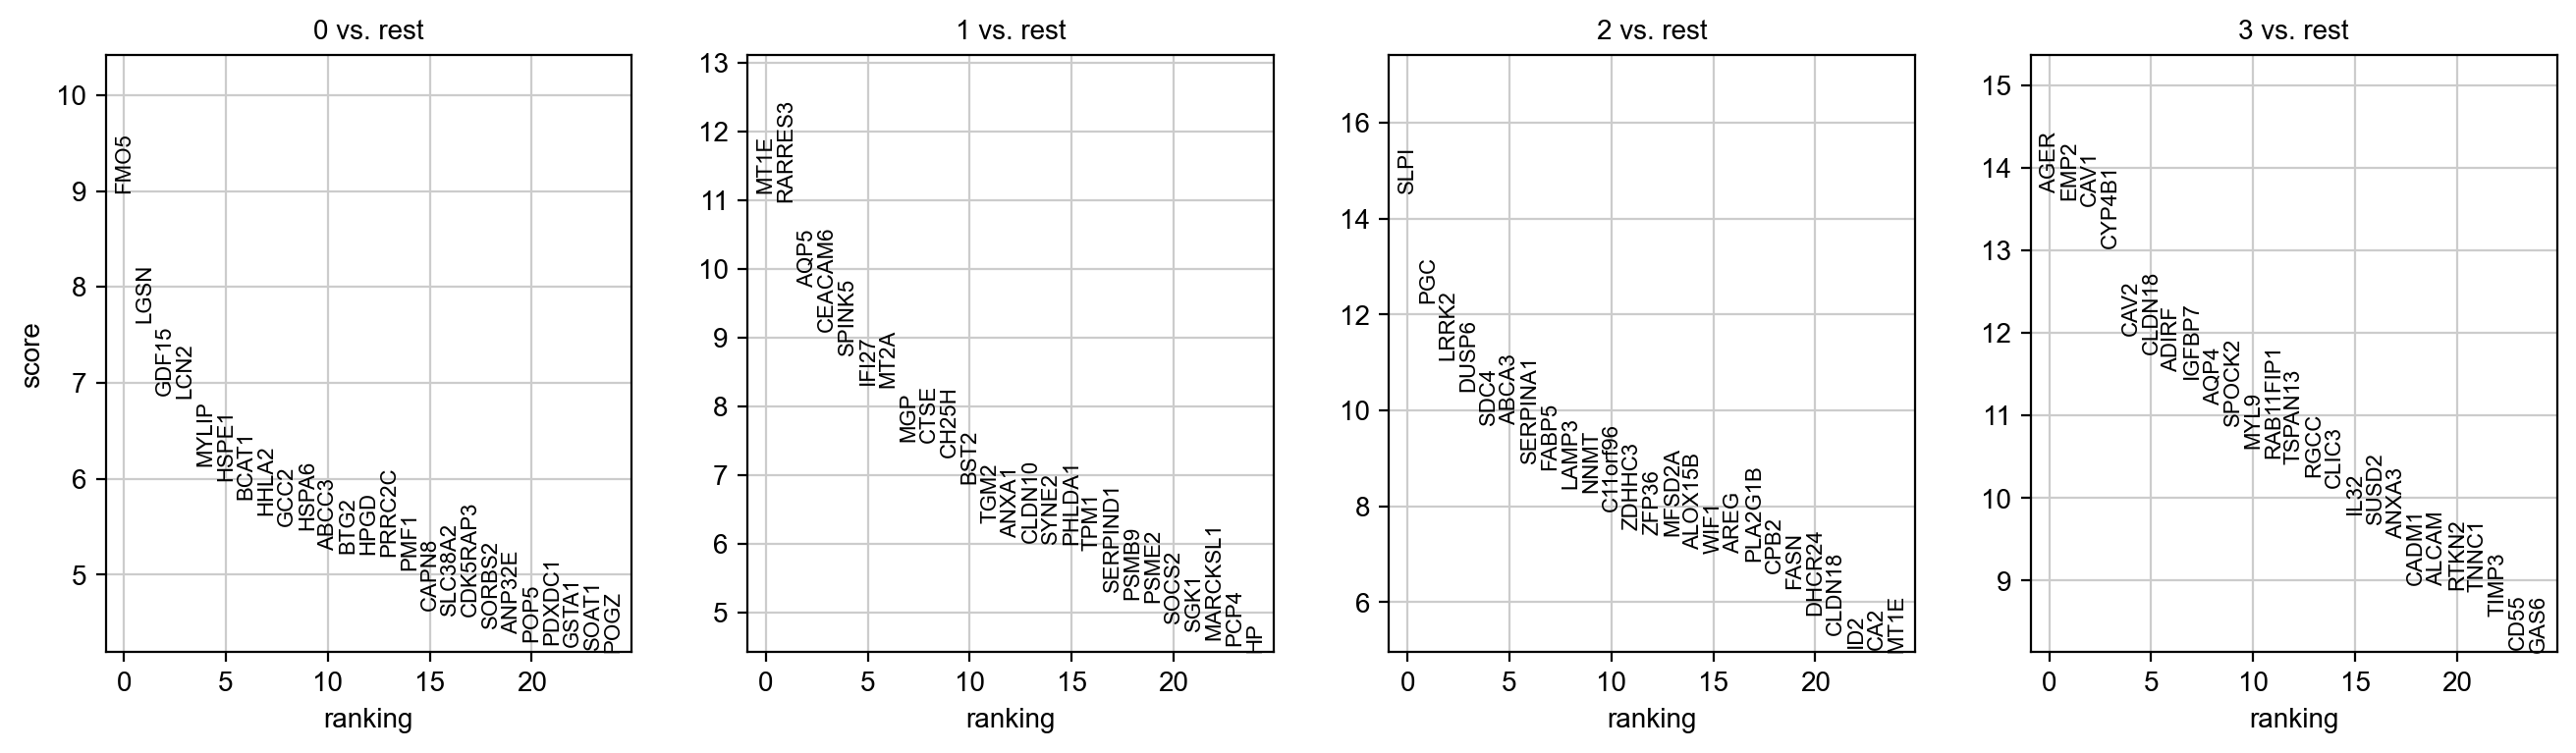

In [172]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', use_raw=False)
#sc.tl.filter_rank_genes_groups(adata, groupby="leiden", use_raw=False,
#                                   key_added='rank_genes_groups_filtered', 
#                                   min_in_group_fraction=0.25, min_fold_change=1, max_out_group_fraction=0.5, compare_abs=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [173]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

0        1         2          3
0     FMO5     MT1E      SLPI       AGER
1     LGSN  RARRES3       PGC       EMP2
2    GDF15     AQP5     LRRK2       CAV1
3     LCN2  CEACAM6     DUSP6     CYP4B1
4    MYLIP   SPINK5      SDC4       CAV2
5    HSPE1    IFI27     ABCA3     CLDN18
6    BCAT1     MT2A  SERPINA1      ADIRF
7    HHLA2      MGP     FABP5     IGFBP7
8     GCC2     CTSE     LAMP3       AQP4
9    HSPA6    CH25H      NNMT     SPOCK2
10   ABCC3     BST2  C11orf96       MYL9
11    BTG2     TGM2    ZDHHC3  RAB11FIP1
12    HPGD    ANXA1     ZFP36    TSPAN13
13  PRRC2C   CLDN10    MFSD2A       RGCC
14    PMF1    SYNE2   ALOX15B      CLIC3

    using 'X_pca' with n_pcs = 60
Storing dendrogram info using `.uns['dendrogram_leiden']`


/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/jor4008/programs/miniconda3/envs/scsarc/lib/python3.9/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

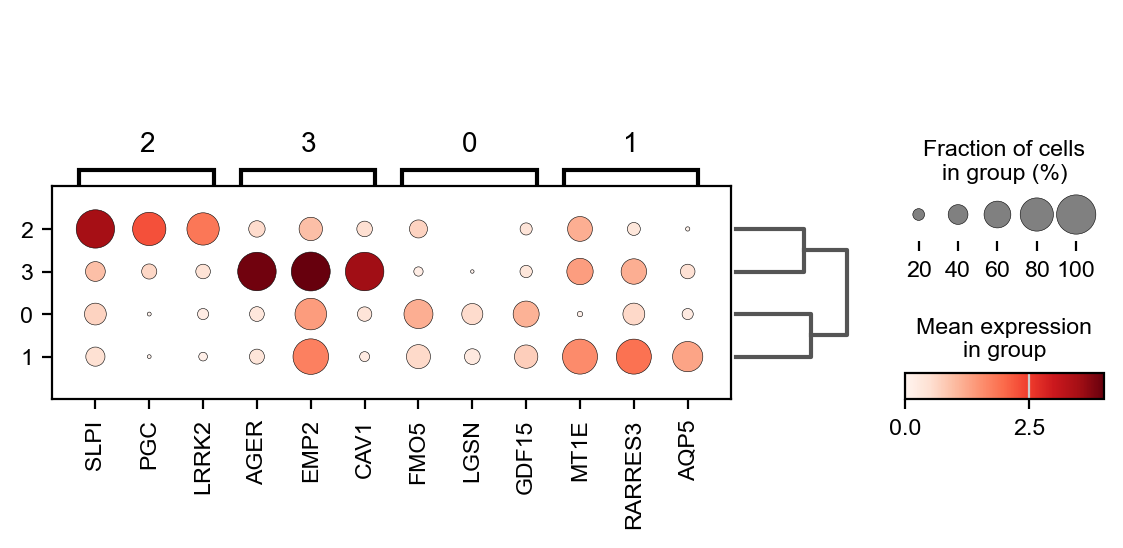

In [174]:
sc.tl.dendrogram(adata,groupby="leiden", n_pcs=60)
sc.pl.rank_genes_groups_dotplot(adata,n_genes=3)#,key="rank_genes_groups_filtered")

In [175]:
resultsFile

'write/luadDost.h5ad'

In [177]:
adata.write(resultsFile)
adata

AnnData object with n_obs × n_vars = 820 × 2135
    obs: 'source', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'label'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'source_colors', 'label_colors', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'